# Neural Network Classifier

In this assignment, your task is to train a type of Neural network classifier on the synthetic dataset that was also used in previous assignements. Please read the assignment entirely before you start coding. Most of the code that implements the neural network functionalities are provided to you. What you are expected to do is fill in certain missing parts that are required and then train two different networks and visualize the estimated posterior.

- <a href='#non-linear-activation-functions'>Question 1</a> (10%) Fill in the code to 
implement the `sigmoid` and `relu` functions and their derivatives. Then, plot all four 
functions to verify that your implementation is correct. See the provided example first.
- <a href='#the-neural-network'>Question 2</a> (80%) Fill in the code inside the 
`NeuralNetwork` class where necessary.
    - <a href='#feedforward1'>a.</a> First, complete the code in the `feedforward` method of the `NeuralNetwork` class. Assuming that the input of the $l$-th layer of the network is $a^{l-1}$ ($a^{l-1}$ can be the non-linear output or activation of a previous layer or initially the input feature vector) then the linear-output of the layer is: $$z^{l}=W a^{l-1} + b$$ Then the non-linear output or "activation" is $a^{l} = f(z^{l})$ where $f(\cdot)$ is the non-linear activation function of the layer, applied element-wise on $z^{l}$. In our case, $f(\cdot)$ is either a `sigmoid` or `relu` function.
    - <a href='#feedforward2'>b.</a> In the `feedforward` method of the `NeuralNetwork` class, write the code that implements the softmax function (see pages 67, 73 of the course slides). If $z^{L}$ is the linear-output of the output layer of the network then applying the softmax function on each of its elements $z^{L}_k$ is described by: 
    
    $$ softmax(z_k) = \frac{\exp(z^{L}_k)}{\sum_{k}\exp(z^{L}_k)}, k=0,...,C-1$$
Note: $z^{L}$ will be a 2-dimensional vector as our synthetic dataset has $C=2$ classes. Consequently $softmax(z^{L}_{0}) = P_{estimated}(y=0 \mid x)$ and $softmax(z^{L}_{1}) = P_{estimated}(y=1 \mid x)$. 
    - <a href='#loss_function'>c.</a> Fill in the `loss_function` method of the `
    NeuralNetwork` class so that it computes the value of the loss used to train the network (see page 68 of the coures slides, where it is refered to as "optimization criterion"): 
$$L(W) = - \sum_{i=1}^{N} \sum_{c=0}^{1} y_{c}^{i} \log (g_{c}(x^{i}; W))$$
where $i$ indexes training examples, $c$ indexes the two classes {0,1} of our synthetic 
data, $W$ is the set of weights of the network and $g_{c}$ is the posterior of class $c$ as 
computed by the network. As implied in pages 68 and 70 of the course slides, for $y^{i}$ 
being the true class label of example $x^{i}$, $y_{c}^{i}$ is the one-hot label encoding of
$y^{i}$, meaning that $y_{c}^{i}=1$ if $y^{i}=c$ and $y_{c}^{i}=0$ if $y^{i} \neq c$. Use 
the gradient checking code (found <a href='#checking'>here</a>) to ensure all your additions 
to the `NeuralNetwork` class are working correctly.
    - <a href='#backprop'>d.</a> Go through and try to understand the `backprop` method of 
the `Neural Network` class which is provided. Briefly explain what is done by the for 
loop at the end of the `backprop` method. Add your explanation in a markdown cell which <a href='#backprop'>here</a>. 
- <a href='#Train-networks'>Question 3</a> (10%) Use the `NeuralNetwork` class to define and train two different neural networks.
    - <a href='#Define-Network'>a.</a> Train a network with a sigmoid non-linear activation 
    function. Then plot the accuracy and error curves. Finally, visualize the estimated 
    posterior. The code needed is provided. 
    - <a href='#Train2'>b.</a> By using the previous question's code as an example, train a 
 network with relu non-linear activation functions. Then with the provided code, plot the accuracy and error 
 curves and visualize the estimated posterior. Briefly  compare the performance of the two 
 networks in a markdown cell which must be added at the end of this notebook <a href='#Compare'>here</a>.

# Code

## Imports

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pickle
from numpy.random import RandomState
from construct_data import construct_data
from gradientChecking import checkNNGradients, compute_numerical_gradient 

## Data Generation - Visualization

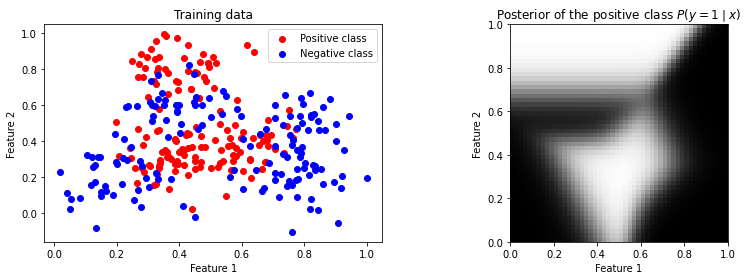

In [2]:
prng = RandomState(1)

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

features, labels, posterior = construct_data(300, 'train', 'nonlinear', plusminus=False)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")

ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.show()

# Our dataset arrays are modified to have a more convenient format for this assignement 
# instead of two arrays features (300,2) and labels (300,)
# we now have a list of 300 elements called data 
# each element of data is a tuple (x,y) 
# where x is  a (2,1) feature vector and y is a scalar label with value either 0 or 1 
data = []
for x, y in zip(features, labels): # creating alternative input
    x = x[:, np.newaxis]
    data.append(np.array([x,y]))

## Helper function for visualizing the posterior 

In [3]:
def visualize_posterior(nnet):
    x_rng = y_rng = np.linspace(0, 1, 50)
    gridx, gridy = np.meshgrid(x_rng, y_rng)
    p_estimated_class1 = np.zeros((50, 50))
    for i in range(50):
        for j in range(50):
            v = np.array([gridx[i, j], gridy[i, j]])
            v = v[:, np.newaxis]
            out, _, _ = nnet.feedforward(v)
            p_estimated_class1[i, j] = out[1]

    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(p_estimated_class1, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title("Estimated $P(y=1 \mid x)$")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    ax1 = fig.add_subplot(1, 3, 2)
    ax1.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title("Ground Truth of the positive class $")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.imshow(posterior-p_estimated_class1+1, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title("Difference between the ground truth and estimated posterior")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")
    plt.show()  
    
def visualize_cost_accuracy_curves(accuracy_training, cost_training):
    # Plots the cost and accuracy evolution during training 
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(cost_training,'r')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Cost')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(accuracy_training)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('Accuracy')
    A = np.array(accuracy_training)
    best_epoch = np.argmax(A)
    print('best_accuracy:', max(accuracy_training), 'achieved at epoch:', best_epoch)


## Analytical Derivative of a Function 
Here we present an example of how we can define (and visualize) each nonlinear function and its derivative. Let us consider the function $f(x)=x^2$. Analytically we know that $f'(x)=2 x$. Thus for some x we can analytically calculate the derivative of x. The following python functions compute $f$ and $f'$. 

In [4]:
def square(x):
    f = x**2
    return f

def square_gradient(x):
    f_prime = 2*x
    return f_prime

We can visualize the function and its derivative using the following commands  

Text(0, 0.5, 'f')

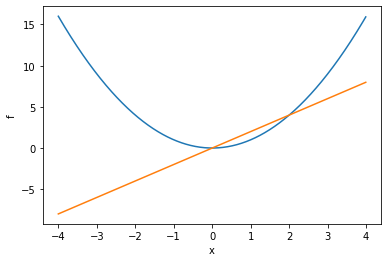

In [5]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
x = np.arange(-4, 4, 0.01)
f = square(x)
ax.plot(x, f)
f_prime = square_gradient(x)
ax.plot(x, f_prime)
ax.set_xlabel('x')
ax.set_ylabel('f')

<a id='non-linear-activation-functions'></a>
# Question 1
## Non-linear activation functions 
Fill in the functions that implement the non-linear functions which are used to produve the 
activations of the neurons of a neural network. Remember that for if $\sigma(x)$ is the 
sigmoid function, its derivative is $\sigma'(x)=\sigma(x)*(1-\sigma(x))$. Finally if 
$relu(x)=max(0,x)$ then $relu'(x>0)= 1$ and $relu'(x<=0)=0$.
#### Note: Do not change the functions and their arguments!

In [6]:
# TO DO (Q1) 
def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

def sigmoid_gradient(z): 
    sig = 1/(1+np.exp(-z))
    g = sig * (1 - sig)
    return g
# /TO DO (Q1)

# TO DO (Q1)
def relu(x):
    g = np.maximum(0, x)
    return g

def relu_gradient(z):
    g = (z > 0) * 1   
    return g
# /TO DO (Q1)

##### Visualize the functions and their gradients by plotting their output in the [-6,6] interval:

Text(0.5, 1.0, 'ReLU function and its derivative plot')

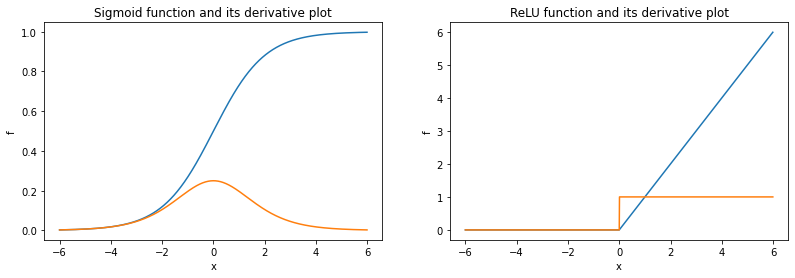

In [7]:
#TO DO (Q1)
fig = plt.figure(figsize=plt.figaspect(0.3))
ax1 = fig.add_subplot(1, 2, 1)
x = np.arange(-6, 6, 0.01)
f = sigmoid(x)
ax1.plot(x, f)
f_prime = sigmoid_gradient(x)
ax1.plot(x, f_prime)
ax1.set_xlabel('x')
ax1.set_ylabel('f')
ax1.set_title('Sigmoid function and its derivative plot')

ax2 = fig.add_subplot(1, 2, 2)
x = np.arange(-6, 6, 0.01)
f = relu(x)
ax2.plot(x, f)
f_prime = relu_gradient(x)
ax2.plot(x, f_prime)
ax2.set_xlabel('x')
ax2.set_ylabel('f')
ax2.set_title('ReLU function and its derivative plot')
# /TO DO (Q1)

# Question 2
<a id='the-neural-network'></a>
## The Neural Network Class 

In this assignement, in order to define, train and use a neural network you are first required to complete the implementation provided below. Every operation related to the network is defined as a method (e.g. `feedforward` , `backpropagation`, etc.) of the `NeuralNetwork` class. You only need to complete the code inside the `feedforward` and `loss_function` methods.

Go through the code to identify what each method inside the class does. Note that when first creating a `NeuralNetwork` class instance (for example as <a href='#Define-Network'> here</a>), the `__init__` method is executed and randomly initializes the network's weights, which then constitute an attribute of that instance. These weights are then modified by calling the `gradient_descent` method used to train the network. 


In [18]:
class NeuralNetwork(object):
    # For Question 2 first focus on __init__ and feedforward
    def __init__(self, nnodes, activation_functions='sigmoid'):
        # nnodes: number of hidden units per layer  - e.g. [2,5,10] indicates a three-layer network with the respective number of nodes
        self.num_layers = len(nnodes)
        # weights, biases: list of the numpy arrays containing model parameters for linear layers
        # sampled originally from a gaussian distribution
        self.sizes = nnodes
        prng = RandomState(2)
        self.biases = [prng.randn(y, 1) for y in nnodes[1:]]
        self.weights = [prng.randn(y, x) for x, y in zip(nnodes[:-1], nnodes[1:])]       
        # non-linearity, specified when the network is initialized 
        self.activation_functions = activation_functions
        self.losses = []  # stores the losses during training
        self.accuracies = []  # stores the accuracies during training 
        self.epoch_best = 0 # epoch during training when accuracy was max
        
    def feedforward(self, x):
        # Computes and returns the output of the network for a given input x
        # In our case x.shape = (2,1), i.e. the input is a 2-dimensional vector
        # It also returns intermediate linear and non-linear outputs of the layers 
        # that can are for backpropagation when traning
        activations = [] # here we store the non-linear outputs of layers
        activations.append(x)
        zs = [] # here we store linear-outputs of layers
        
        # feedforward computation through all layers except the output layer
        for l in range(len(self.weights)-1):
            b = self.biases[l]
            w = self.weights[l]

            ##### TO DO Q2 linear output ##### 
            z = w @ x + b
            ##### /TO DO Q2 linear output #####

            if self.activation_functions == 'sigmoid':
            ##### TO DO Q2 sigmoid ##### 
                activation = sigmoid(z)
            ##### /TO DO Q2 sigmoid #####

            elif self.activation_functions == 'relu':   
                
            ##### TO DO Q2 relu ##### 
                activation = relu(z)
            ##### /TO DO Q2 relu #####
            
            # save z values for backprop (linear output of each layer)
            zs.append(z) 
            # save activations for backprop (non-linear output of each layer)
            activations.append(activation)
            # the input at the next layer is the activation of the previous layer
            x = activation  
            
        # feedforward computation through the output layer
        w = self.weights[-1]
        b = self.biases[-1]
        z = np.dot(w, x) + b # linear-output of output-layer
        
        ##### /TO DO Q2 softmax #####
                
        softmax_output = np.exp(z) / np.sum(np.exp(z), axis=0)  
        ##### /TO DO Q2 softmax #####

        activations.append(softmax_output)
        zs.append(z)
        #print(activations[-1])
        return softmax_output, zs, activations
    
    def loss_function(self,X):
        # computes the cross entropy cost 
        # X is a list, each element of which is a tuple (x,y) 
        # where x is the input and y is the ground truth label
        # x has shape (2,1) and y is a scalar
        
        counter = 0 #Initialise number of observations
        loss = 0 # initializing cost as 0
        for x, y in X: # looping elements of list X, each element is a pair x,y 
            # Note: y is a scalar with value either 0 or 1
            # Note: The cost formula requires a one-hot encoded version of y
            
            ##### /TO DO Q2 cost function #####
            
            # step 1 feedforward computation
            softmax_output, zs, activations = self.feedforward(x)

            # step 2 cost value computation using x,y 
            if y == 0:
                y_one_hot = np.array([[1], [0]])
            else:
                y_one_hot = np.array([[0], [1]]) 
            
            cost = -np.sum(y_one_hot * np.log(softmax_output))
               
            # step 3 increment total_cost 
            loss += cost
            ##### /TO DO Q2 cost function #####
            
        return loss

    
    def gradient_descent(self, training_data, epochs, lr, test_data=None):
        # training_data is a list of tuples ([x1,x2],y) where y is the class and [x1,x2] is numpy array
        # lr is the learning_rate, it is scalar
        # epochs is a scalar value for the number of times the network 
        # is going to update its parameters after computing the gradient 
        # using all training examples
        
        n_train = len(training_data)
        accuracy_max = 0.0
        for j in range(epochs):
            # compute gradient using backprop and do gradient descent step to update params
            self.update_params(training_data, lr) 
            # compute loss value 
            loss = self.loss_function(training_data)
            # save loss value for visualization 
            self.losses.append(loss/n_train)
            if test_data:
                n_test = len(test_data)
                correct = self.evaluate(test_data)
                print ("Epoch {0}: Accuracy {1} / {2} loss: {3}".format(j, correct, n_test, loss/len(training_data)))
                accucary = correct / n_test
                self.accuracies.append(accucary)
                # if accuracy increased then store params 
                if accucary >= accuracy_max:
                    accuracy_max = accucary
                    w_best = self.weights
                    b_best = self.biases
                    epoch_best = j
                    # print('improved accuracy @ {}, {}'.format(j, accuracy_max))
            else:
                print ("No test_data given")
        if test_data:
            print('Model with highest accuracy {} achieved at epoch {}'.format(accuracy_max, epoch_best))
            # restore the weights and biases of the model with the highest accuracy
            self.weights = w_best 
            self.biases = b_best
            self.epoch_best = epoch_best
                
    def update_params(self, X, lr):
        # X is all the training data
        # X contains pairs (x,y) where x is the feature vector and y its class label
        N = len(X)
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        #Gradient Descent parameter updates
        for x, y in X:
            delta_grad_b, delta_grad_w = self.backprop(x, y) # take an example backpropagate to find the gradients
            grad_b = [nb+dnb for nb, dnb in zip(grad_b, delta_grad_b)] # accumulate gradients for biases
            grad_w = [nw+dnw for nw, dnw in zip(grad_w, delta_grad_w)] # accumulate gradients for weights
        
        # Update the weights and biases using the gradient of the cost computed using the whole training_dataset
        # divide by N to scale the overall gradient by the number of training examples
        self.weights = [w-lr*nw/N for w, nw in zip(self.weights, grad_w)]  
        self.biases = [b-lr*nb/N for b, nb in zip(self.biases,  grad_b)]
        
        
    def backprop(self, x, y):
        #Returns (grad_b, grad_w) representing the
        #gradients for the cost function  wrt b and w, initialized as zeros 
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        ######### Forward pass #########
        dummy, zs, activations= self.feedforward(x) 
        
        # one hot encoding of the true class label y
        # if y=1 then the one-hot encoding of y is y =[0, 1]
        # if y=0 then the one-hot encoding of y is y =[1, 0]
        if y == 0:
            y_one_hot = np.array([[1], [0]])
        else:
            y_one_hot = np.array([[0], [1]])
        
        ######## Backward pass ##########        
        # Grad at the ouput layer 
        
        dL_dz = activations[-1] - y_one_hot  # dL/dz (slide 51 derives this)
        # also this is the δ of slide 63 i.e the sensitivity of the loss to the activations of output layer
        
        # grad wrt the parameters (w,b) of the output layer     
        # for the grad of the loss wrt to the bias we have:
        # Given z = Wa + b  (we omit z(l) and a(l-1) for simplicity)
        # Chain_rule: dL_db = dL_dz * dz_db = dL_dz * 1 = dL_dz 
        grad_b[-1] = dL_dz  
        
        # for the grad of the loss wrt to the weight matrix with elements Wij we have:
        # dL_dWij = dL_dzi * dz[i]_dWij = dL_dz[i] * a[j]
        # which can be written as the following dot product 
        
        grad_w[-1] = np.dot(dL_dz, activations[-2].T)
        # Note: the resulting shape of grad_w[-1] is (2, num nodes of previous layer)
        # which is exactly the shape of the weight matrix mapping of the output layer 
        
        # By uncommenting the following lines the you can printing the shapes 
        # of each variable used to compute the gradient at the output layer
        '''
        print('---- shapes')
        print('output-layer')
        print('activation',activations[-1].shape) 
        print('z', zs[-1].shape)
        print('dL_dz',dL_dz.shape)
        print('grad_b:',grad_b[-1].shape,' grad_w:',grad_w[-1].shape)
        '''
        ############# TO DO Q2b explain what is done by following for loop###############
        
        # Grad at previous layers
        delta = dL_dz # delta of output layer
        L = self.num_layers # considering input layer + hidden layers + output layer
        # zs has L-1 elements , activations has L elements , self.weights of L-1 elements
        # start from 2nd-to-last layer (hence the L-2 index) and move backwards 
        for l in range(L-2, 0, -1): 
            # z is the linear output of the l-th layer
            z = zs[l-1] 
            
            # activation if the activation of the (l-1)-th layer
            activation=activations[l-1] 
            
            # weights that map the output of the 
            # l-th layer to the input of the (l+1)-th layer
            weights=self.weights[l] 
            
            # compute the value of the gradient of the non-linear function of the l-th layer 
            # evaluated at z: act_g = f'(z) 
            if self.activation_functions=='relu': act_g = relu_gradient(z)
            elif self.activation_functions=='sigmoid': act_g = sigmoid_gradient(z)
            
            # backpropagate delta from (l+1)-th layer to l-th layer
            prod  = np.dot(weights.T, delta)    
    
            delta = prod * act_g
            
            # gradients wrt to the parameters of the l-th layer
            grad_b[l-1] = delta 
            grad_w[l-1] = np.dot(delta, activation.T) 
            
            # By uncommenting the following lines the function 
            # will be printing the shapes of each variable             
            '''
            print('---- shapes')
            print('layer:',l)  
            print('activation ',activation.shape)
            print('z ', z.shape)
            print('w ',weights.shape)       
            print('prod ',prod.shape,'act_g',act_g.shape)
            print('delta ',delta.shape)
            print('grad_b ',grad_b[-l].shape,' grad_w ',grad_w[-l].shape) 
            '''
        return (grad_b, grad_w)
        ############# TO DO Q2b explain what is done by above for loop###############

    def evaluate(self, data):
        correct = 0
        for x, y in data:
            # we do not need to save activations and zs when classifying data 
            # we only care about the outupt 
            output, _, _ = self.feedforward(x)
            # predicted class is the index in the ouptut with maximal propability
            correct = correct + int(y == np.argmax(output))
        return correct


<a id='backprop'></a>
## Explanation of the backprop for loop



Answer:

The Backpropogation is the stage when the network 'learns'. In order to learn, the network calculates the change  in the loss (i.e. the error between the network's output and the expected label) in relation to the change in the previous parameters. As there are multiple layers of parameters, this change is propagated from the final layer till the last via the chain rule. 
The for loop is calculating the gradients of the loss with respect to all the weights and biases of the previous layers by applying the chain rule.








<a id='checking'></a>
## Gradient checking:
We are going to use $gradient$ $checking$ to check if the numerical (using approximations) 
and analytical (computed by our backprop implementation) gradient computations match. To 
test that we are going to check the gradients computed for a small neural network. 
Suppose we have a neural network with 2 dimensional inputs , 2 hidden layers of 4 neurons 
each with sigmoid non-linearities and an output layer of 2 neurons with sigmoid non-
linearity. This network is initialized as shown by the code in the next cell.

In [19]:
nnodes2 = [2, 4, 4, 2]
activation_functions2 = 'sigmoid' 
nnet_checking = NeuralNetwork(nnodes2, activation_functions2)

We are going to use a few training examples (m=50) to check if the analytical and numerical gradients match.

In [20]:
m = 50 # using 50 examples to do gradient checking 
train_data = data[1:m] 
checkNNGradients(nnet_checking, train_data)  # compute_numerical_gradient 

Relative difference 2.9935473952640777e-07 for layer 0 parameters
Analytical and numerical gradients match
as relative distance is less than 1e-5
Relative difference 5.876024348917915e-07 for layer 1 parameters
Analytical and numerical gradients match
as relative distance is less than 1e-5
Relative difference 5.049300351341977e-07 for layer 2 parameters
Analytical and numerical gradients match
as relative distance is less than 1e-5


# Question 3
<a id='Define-Network'></a>
## Define a Network 
To initialize a Neural Network we must provide two arguments: $nnodes$ and activation_functions. $nnodes$ is a list. Each element of $nnodes$ defines the number of neurons of each layer of the network. By convention the first element of $nnodes$ defines the dimensionality of the input layer of the network that is not associated with any weights and biases (i.e if the input to a network is $x \in R^{2}$ then the dimensionality of the input layer is $2$). The rest of the elements of $nnodes$ are used to initialize the weigths and biases of the hidden layers and the output layer. The activation_functions argument is a string that defines the type of non-linear function to be used for each neuron of the hidden layer. Our implementation supports relu and sigmoid as non-linear activation functions. 

In [21]:
nnodes = [2, 10, 10, 2]
activation_functions = 'sigmoid' # this can either be 'sigmoid' or 'relu'
nnet = NeuralNetwork(nnodes, activation_functions) # creating a NeuralNetwork instance
# accessing the weights attribute of the nnet instance we can print weight shapes per layer
print(['layer {}: w {}'.format(layer, w.shape) for w, layer in zip(nnet.weights, range(len(nnet.weights)))]) 

['layer 0: w (10, 2)', 'layer 1: w (10, 10)', 'layer 2: w (2, 10)']


## Train a network with sigmoid activation functions.
Note that for each training epoch we compute the mean cost and accuracy on the training set. 
Once the training is completed visualize the cost / accuracy curves and the estimated posterior using the provided code. It is recomended that you keep the learning rate and number of epochs as provided below.

In [22]:
learning_rate = 2
epochs = 5000  # usually has converged for that many epochs
train_data = data
test_data = data 
nnet.gradient_descent(train_data, epochs, learning_rate, test_data)

Epoch 0: Accuracy 150 / 300 loss: 3.483158241515567
Epoch 1: Accuracy 150 / 300 loss: 2.660684441964038
Epoch 2: Accuracy 150 / 300 loss: 2.5494340874402064
Epoch 3: Accuracy 150 / 300 loss: 1.3534527867117758
Epoch 4: Accuracy 150 / 300 loss: 1.4363862269113086
Epoch 5: Accuracy 150 / 300 loss: 0.9673692133965774
Epoch 6: Accuracy 150 / 300 loss: 0.8973147567921474
Epoch 7: Accuracy 150 / 300 loss: 0.7885149621945051
Epoch 8: Accuracy 150 / 300 loss: 0.7509202174490244
Epoch 9: Accuracy 150 / 300 loss: 0.7198429324132003
Epoch 10: Accuracy 150 / 300 loss: 0.7060588088768246
Epoch 11: Accuracy 150 / 300 loss: 0.6964837340050933
Epoch 12: Accuracy 150 / 300 loss: 0.6914407013048817
Epoch 13: Accuracy 150 / 300 loss: 0.6880043338615661
Epoch 14: Accuracy 167 / 300 loss: 0.6858601650570489
Epoch 15: Accuracy 150 / 300 loss: 0.6842678693015406
Epoch 16: Accuracy 203 / 300 loss: 0.6830657892275953
Epoch 17: Accuracy 152 / 300 loss: 0.6820438567852721
Epoch 18: Accuracy 195 / 300 loss: 0.681

Epoch 153: Accuracy 169 / 300 loss: 0.6581021566676686
Epoch 154: Accuracy 191 / 300 loss: 0.6572569031025424
Epoch 155: Accuracy 169 / 300 loss: 0.6578963710895682
Epoch 156: Accuracy 191 / 300 loss: 0.6569318882093145
Epoch 157: Accuracy 169 / 300 loss: 0.6574468915356485
Epoch 158: Accuracy 190 / 300 loss: 0.6564020951292084
Epoch 159: Accuracy 169 / 300 loss: 0.656805835716314
Epoch 160: Accuracy 189 / 300 loss: 0.6557249634759784
Epoch 161: Accuracy 168 / 300 loss: 0.6560404734030348
Epoch 162: Accuracy 186 / 300 loss: 0.6549647093731912
Epoch 163: Accuracy 168 / 300 loss: 0.6552187538110986
Epoch 164: Accuracy 185 / 300 loss: 0.6541808117859893
Epoch 165: Accuracy 168 / 300 loss: 0.6543991211518425
Epoch 166: Accuracy 183 / 300 loss: 0.6534212230038684
Epoch 167: Accuracy 168 / 300 loss: 0.6536257199505655
Epoch 168: Accuracy 183 / 300 loss: 0.6527201394785914
Epoch 169: Accuracy 168 / 300 loss: 0.6529279262791639
Epoch 170: Accuracy 184 / 300 loss: 0.6520988782043406
Epoch 171: 

Epoch 306: Accuracy 191 / 300 loss: 0.6379133943737291
Epoch 307: Accuracy 168 / 300 loss: 0.6380208684311547
Epoch 308: Accuracy 191 / 300 loss: 0.6376463262395131
Epoch 309: Accuracy 168 / 300 loss: 0.6377474784058494
Epoch 310: Accuracy 191 / 300 loss: 0.6373739496185679
Epoch 311: Accuracy 168 / 300 loss: 0.6374687001059073
Epoch 312: Accuracy 191 / 300 loss: 0.6370962551723284
Epoch 313: Accuracy 168 / 300 loss: 0.6371845775905404
Epoch 314: Accuracy 191 / 300 loss: 0.6368133275930621
Epoch 315: Accuracy 168 / 300 loss: 0.6368952448467113
Epoch 316: Accuracy 191 / 300 loss: 0.6365253320722456
Epoch 317: Accuracy 168 / 300 loss: 0.6366009102531667
Epoch 318: Accuracy 191 / 300 loss: 0.6362324984186744
Epoch 319: Accuracy 168 / 300 loss: 0.6363018391749443
Epoch 320: Accuracy 192 / 300 loss: 0.6359351038109301
Epoch 321: Accuracy 168 / 300 loss: 0.6359983356916359
Epoch 322: Accuracy 192 / 300 loss: 0.6356334551176799
Epoch 323: Accuracy 168 / 300 loss: 0.6356907243782363
Epoch 324:

Epoch 456: Accuracy 207 / 300 loss: 0.5888176664628022
Epoch 457: Accuracy 172 / 300 loss: 0.5869175408450515
Epoch 458: Accuracy 208 / 300 loss: 0.5870672826172805
Epoch 459: Accuracy 172 / 300 loss: 0.5851127421051805
Epoch 460: Accuracy 207 / 300 loss: 0.5852775242907957
Epoch 461: Accuracy 172 / 300 loss: 0.583271570167706
Epoch 462: Accuracy 206 / 300 loss: 0.5834505135441841
Epoch 463: Accuracy 173 / 300 loss: 0.5813964682183527
Epoch 464: Accuracy 205 / 300 loss: 0.5815885436980492
Epoch 465: Accuracy 174 / 300 loss: 0.5794900345806843
Epoch 466: Accuracy 207 / 300 loss: 0.5796940656438866
Epoch 467: Accuracy 181 / 300 loss: 0.5775550097977926
Epoch 468: Accuracy 208 / 300 loss: 0.5777696815686454
Epoch 469: Accuracy 183 / 300 loss: 0.5755942698943987
Epoch 470: Accuracy 211 / 300 loss: 0.5758181444370362
Epoch 471: Accuracy 183 / 300 loss: 0.5736108237686346
Epoch 472: Accuracy 212 / 300 loss: 0.5738423606040539
Epoch 473: Accuracy 185 / 300 loss: 0.5716078120938645
Epoch 474: 

Epoch 608: Accuracy 230 / 300 loss: 0.4968802600631672
Epoch 609: Accuracy 227 / 300 loss: 0.49672149282678096
Epoch 610: Accuracy 230 / 300 loss: 0.4966181632702424
Epoch 611: Accuracy 227 / 300 loss: 0.4964669743937342
Epoch 612: Accuracy 229 / 300 loss: 0.4963648422476505
Epoch 613: Accuracy 227 / 300 loss: 0.49622075768510504
Epoch 614: Accuracy 229 / 300 loss: 0.4961199441325821
Epoch 615: Accuracy 227 / 300 loss: 0.495982515763951
Epoch 616: Accuracy 229 / 300 loss: 0.49588313018437874
Epoch 617: Accuracy 227 / 300 loss: 0.4957519346923266
Epoch 618: Accuracy 230 / 300 loss: 0.495654074247533
Epoch 619: Accuracy 226 / 300 loss: 0.4955287120377535
Epoch 620: Accuracy 230 / 300 loss: 0.49543246137596136
Epoch 621: Accuracy 226 / 300 loss: 0.4953125555360634
Epoch 622: Accuracy 230 / 300 loss: 0.49521798662038286
Epoch 623: Accuracy 227 / 300 loss: 0.49510318191329494
Epoch 624: Accuracy 230 / 300 loss: 0.49501035397944615
Epoch 625: Accuracy 227 / 300 loss: 0.49490031586816846
Epoc

Epoch 759: Accuracy 230 / 300 loss: 0.487498109910759
Epoch 760: Accuracy 230 / 300 loss: 0.4874605949716033
Epoch 761: Accuracy 230 / 300 loss: 0.4874232048622534
Epoch 762: Accuracy 230 / 300 loss: 0.48738593854933254
Epoch 763: Accuracy 230 / 300 loss: 0.4873487949859147
Epoch 764: Accuracy 230 / 300 loss: 0.4873117731667121
Epoch 765: Accuracy 230 / 300 loss: 0.48727487207809794
Epoch 766: Accuracy 230 / 300 loss: 0.4872380907423016
Epoch 767: Accuracy 230 / 300 loss: 0.48720142817733847
Epoch 768: Accuracy 230 / 300 loss: 0.48716488343232084
Epoch 769: Accuracy 230 / 300 loss: 0.4871284555553972
Epoch 770: Accuracy 230 / 300 loss: 0.4870921436218925
Epoch 771: Accuracy 230 / 300 loss: 0.4870559467087018
Epoch 772: Accuracy 230 / 300 loss: 0.48701986391666613
Epoch 773: Accuracy 230 / 300 loss: 0.4869838943501559
Epoch 774: Accuracy 230 / 300 loss: 0.4869480371348112
Epoch 775: Accuracy 230 / 300 loss: 0.4869122914012969
Epoch 776: Accuracy 230 / 300 loss: 0.48687665629933463
Epoch

Epoch 909: Accuracy 230 / 300 loss: 0.4828920979594767
Epoch 910: Accuracy 230 / 300 loss: 0.4828666282995393
Epoch 911: Accuracy 230 / 300 loss: 0.48284121326169344
Epoch 912: Accuracy 230 / 300 loss: 0.48281585264626375
Epoch 913: Accuracy 230 / 300 loss: 0.48279054625495327
Epoch 914: Accuracy 230 / 300 loss: 0.48276529389082784
Epoch 915: Accuracy 230 / 300 loss: 0.4827400953582905
Epoch 916: Accuracy 230 / 300 loss: 0.482714950463067
Epoch 917: Accuracy 231 / 300 loss: 0.48268985901218336
Epoch 918: Accuracy 231 / 300 loss: 0.48266482081394674
Epoch 919: Accuracy 231 / 300 loss: 0.482639835677928
Epoch 920: Accuracy 231 / 300 loss: 0.4826149034149431
Epoch 921: Accuracy 231 / 300 loss: 0.4825900238370328
Epoch 922: Accuracy 231 / 300 loss: 0.4825651967574464
Epoch 923: Accuracy 231 / 300 loss: 0.482540421990624
Epoch 924: Accuracy 231 / 300 loss: 0.4825156993521773
Epoch 925: Accuracy 231 / 300 loss: 0.4824910286588735
Epoch 926: Accuracy 231 / 300 loss: 0.482466409728622
Epoch 92

Epoch 1059: Accuracy 229 / 300 loss: 0.4795911948856573
Epoch 1060: Accuracy 229 / 300 loss: 0.47957216631763167
Epoch 1061: Accuracy 229 / 300 loss: 0.4795531708283093
Epoch 1062: Accuracy 229 / 300 loss: 0.4795342083021398
Epoch 1063: Accuracy 229 / 300 loss: 0.4795152786237234
Epoch 1064: Accuracy 229 / 300 loss: 0.4794963816778159
Epoch 1065: Accuracy 229 / 300 loss: 0.4794775173493204
Epoch 1066: Accuracy 229 / 300 loss: 0.4794586855232909
Epoch 1067: Accuracy 229 / 300 loss: 0.47943988608492827
Epoch 1068: Accuracy 229 / 300 loss: 0.47942111891957295
Epoch 1069: Accuracy 229 / 300 loss: 0.4794023839127124
Epoch 1070: Accuracy 229 / 300 loss: 0.47938368094997014
Epoch 1071: Accuracy 229 / 300 loss: 0.47936500991710884
Epoch 1072: Accuracy 229 / 300 loss: 0.4793463707000264
Epoch 1073: Accuracy 229 / 300 loss: 0.47932776318475484
Epoch 1074: Accuracy 229 / 300 loss: 0.47930918725745747
Epoch 1075: Accuracy 229 / 300 loss: 0.4792906428044289
Epoch 1076: Accuracy 229 / 300 loss: 0.47

Epoch 1209: Accuracy 230 / 300 loss: 0.4770449424622412
Epoch 1210: Accuracy 230 / 300 loss: 0.47702963479016053
Epoch 1211: Accuracy 230 / 300 loss: 0.47701434368052353
Epoch 1212: Accuracy 230 / 300 loss: 0.47699906902338407
Epoch 1213: Accuracy 230 / 300 loss: 0.4769838107087263
Epoch 1214: Accuracy 230 / 300 loss: 0.4769685686264607
Epoch 1215: Accuracy 230 / 300 loss: 0.4769533426664239
Epoch 1216: Accuracy 230 / 300 loss: 0.4769381327183772
Epoch 1217: Accuracy 230 / 300 loss: 0.47692293867200497
Epoch 1218: Accuracy 230 / 300 loss: 0.47690776041691074
Epoch 1219: Accuracy 230 / 300 loss: 0.4768925978426196
Epoch 1220: Accuracy 230 / 300 loss: 0.4768774508385719
Epoch 1221: Accuracy 230 / 300 loss: 0.4768623192941254
Epoch 1222: Accuracy 230 / 300 loss: 0.4768472030985515
Epoch 1223: Accuracy 230 / 300 loss: 0.4768321021410329
Epoch 1224: Accuracy 230 / 300 loss: 0.4768170163106645
Epoch 1225: Accuracy 230 / 300 loss: 0.47680194549644994
Epoch 1226: Accuracy 230 / 300 loss: 0.476

Epoch 1358: Accuracy 230 / 300 loss: 0.4748848441695717
Epoch 1359: Accuracy 230 / 300 loss: 0.4748707156875637
Epoch 1360: Accuracy 230 / 300 loss: 0.47485658552018367
Epoch 1361: Accuracy 230 / 300 loss: 0.47484245352340165
Epoch 1362: Accuracy 230 / 300 loss: 0.47482831955276245
Epoch 1363: Accuracy 230 / 300 loss: 0.4748141834633826
Epoch 1364: Accuracy 230 / 300 loss: 0.47480004510994933
Epoch 1365: Accuracy 230 / 300 loss: 0.4747859043467149
Epoch 1366: Accuracy 230 / 300 loss: 0.4747717610274977
Epoch 1367: Accuracy 230 / 300 loss: 0.47475761500567565
Epoch 1368: Accuracy 230 / 300 loss: 0.474743466134182
Epoch 1369: Accuracy 230 / 300 loss: 0.4747293142655078
Epoch 1370: Accuracy 230 / 300 loss: 0.4747151592516939
Epoch 1371: Accuracy 230 / 300 loss: 0.4747010009443319
Epoch 1372: Accuracy 230 / 300 loss: 0.4746868391945567
Epoch 1373: Accuracy 230 / 300 loss: 0.47467267385304696
Epoch 1374: Accuracy 230 / 300 loss: 0.4746585047700211
Epoch 1375: Accuracy 230 / 300 loss: 0.4746

Epoch 1508: Accuracy 229 / 300 loss: 0.472657044298216
Epoch 1509: Accuracy 229 / 300 loss: 0.47264076303635744
Epoch 1510: Accuracy 229 / 300 loss: 0.47262445228113154
Epoch 1511: Accuracy 229 / 300 loss: 0.47260811179863804
Epoch 1512: Accuracy 229 / 300 loss: 0.47259174135432847
Epoch 1513: Accuracy 229 / 300 loss: 0.4725753407130093
Epoch 1514: Accuracy 229 / 300 loss: 0.47255890963884356
Epoch 1515: Accuracy 229 / 300 loss: 0.47254244789535277
Epoch 1516: Accuracy 229 / 300 loss: 0.47252595524542473
Epoch 1517: Accuracy 229 / 300 loss: 0.4725094314513092
Epoch 1518: Accuracy 229 / 300 loss: 0.472492876274625
Epoch 1519: Accuracy 229 / 300 loss: 0.47247628947636133
Epoch 1520: Accuracy 229 / 300 loss: 0.4724596708168838
Epoch 1521: Accuracy 229 / 300 loss: 0.4724430200559332
Epoch 1522: Accuracy 229 / 300 loss: 0.4724263369526303
Epoch 1523: Accuracy 229 / 300 loss: 0.4724096212654817
Epoch 1524: Accuracy 229 / 300 loss: 0.47239287275238023
Epoch 1525: Accuracy 229 / 300 loss: 0.47

Epoch 1655: Accuracy 229 / 300 loss: 0.46981618503817446
Epoch 1656: Accuracy 229 / 300 loss: 0.469792812333291
Epoch 1657: Accuracy 229 / 300 loss: 0.4697693715236134
Epoch 1658: Accuracy 229 / 300 loss: 0.46974586234121507
Epoch 1659: Accuracy 229 / 300 loss: 0.46972228451835046
Epoch 1660: Accuracy 229 / 300 loss: 0.469698637787458
Epoch 1661: Accuracy 229 / 300 loss: 0.46967492188115784
Epoch 1662: Accuracy 229 / 300 loss: 0.46965113653224855
Epoch 1663: Accuracy 229 / 300 loss: 0.46962728147371413
Epoch 1664: Accuracy 229 / 300 loss: 0.46960335643871237
Epoch 1665: Accuracy 229 / 300 loss: 0.46957936116058147
Epoch 1666: Accuracy 229 / 300 loss: 0.46955529537283575
Epoch 1667: Accuracy 229 / 300 loss: 0.4695311588091633
Epoch 1668: Accuracy 229 / 300 loss: 0.46950695120342356
Epoch 1669: Accuracy 229 / 300 loss: 0.4694826722896468
Epoch 1670: Accuracy 229 / 300 loss: 0.46945832180202934
Epoch 1671: Accuracy 229 / 300 loss: 0.46943389947493214
Epoch 1672: Accuracy 229 / 300 loss: 0

Epoch 1803: Accuracy 229 / 300 loss: 0.46834441308148606
Epoch 1804: Accuracy 233 / 300 loss: 0.4681038432815183
Epoch 1805: Accuracy 229 / 300 loss: 0.46790579966838597
Epoch 1806: Accuracy 233 / 300 loss: 0.4677611672013984
Epoch 1807: Accuracy 228 / 300 loss: 0.4676399339763855
Epoch 1808: Accuracy 230 / 300 loss: 0.46754503585014145
Epoch 1809: Accuracy 228 / 300 loss: 0.467462944242215
Epoch 1810: Accuracy 230 / 300 loss: 0.46739421801084036
Epoch 1811: Accuracy 228 / 300 loss: 0.46733252151833
Epoch 1812: Accuracy 230 / 300 loss: 0.4672777842707527
Epoch 1813: Accuracy 228 / 300 loss: 0.46722693170461244
Epoch 1814: Accuracy 230 / 300 loss: 0.467179784083125
Epoch 1815: Accuracy 228 / 300 loss: 0.46713479878145214
Epoch 1816: Accuracy 229 / 300 loss: 0.4670918213711395
Epoch 1817: Accuracy 228 / 300 loss: 0.4670500531108659
Epoch 1818: Accuracy 229 / 300 loss: 0.467009385490472
Epoch 1819: Accuracy 228 / 300 loss: 0.4669693923576874
Epoch 1820: Accuracy 229 / 300 loss: 0.46693000

Epoch 1949: Accuracy 229 / 300 loss: 0.46432774089046785
Epoch 1950: Accuracy 231 / 300 loss: 0.4645732875931923
Epoch 1951: Accuracy 229 / 300 loss: 0.4647511821913205
Epoch 1952: Accuracy 231 / 300 loss: 0.46516273653711493
Epoch 1953: Accuracy 228 / 300 loss: 0.46545644073075143
Epoch 1954: Accuracy 230 / 300 loss: 0.46613842999052735
Epoch 1955: Accuracy 227 / 300 loss: 0.466598066610653
Epoch 1956: Accuracy 228 / 300 loss: 0.46771725601599323
Epoch 1957: Accuracy 228 / 300 loss: 0.4683923539480955
Epoch 1958: Accuracy 228 / 300 loss: 0.4701950561237325
Epoch 1959: Accuracy 229 / 300 loss: 0.4710886349741997
Epoch 1960: Accuracy 228 / 300 loss: 0.47388021861563573
Epoch 1961: Accuracy 228 / 300 loss: 0.4748420497861838
Epoch 1962: Accuracy 228 / 300 loss: 0.478858894946576
Epoch 1963: Accuracy 229 / 300 loss: 0.4794381774196726
Epoch 1964: Accuracy 229 / 300 loss: 0.4845651673284287
Epoch 1965: Accuracy 229 / 300 loss: 0.48400663756087264
Epoch 1966: Accuracy 230 / 300 loss: 0.4895

Epoch 2096: Accuracy 228 / 300 loss: 0.46745753091606684
Epoch 2097: Accuracy 228 / 300 loss: 0.4665324167800326
Epoch 2098: Accuracy 227 / 300 loss: 0.4673342102355708
Epoch 2099: Accuracy 228 / 300 loss: 0.4664632821157742
Epoch 2100: Accuracy 227 / 300 loss: 0.4673324142260205
Epoch 2101: Accuracy 228 / 300 loss: 0.46649653164637406
Epoch 2102: Accuracy 228 / 300 loss: 0.4674464082755884
Epoch 2103: Accuracy 227 / 300 loss: 0.46662572698002225
Epoch 2104: Accuracy 228 / 300 loss: 0.4676674141957659
Epoch 2105: Accuracy 226 / 300 loss: 0.4668410526269194
Epoch 2106: Accuracy 228 / 300 loss: 0.4679821122915336
Epoch 2107: Accuracy 227 / 300 loss: 0.4671280459140659
Epoch 2108: Accuracy 228 / 300 loss: 0.4683709670083802
Epoch 2109: Accuracy 228 / 300 loss: 0.4674664693775194
Epoch 2110: Accuracy 228 / 300 loss: 0.4688070097060129
Epoch 2111: Accuracy 228 / 300 loss: 0.4678299210013006
Epoch 2112: Accuracy 228 / 300 loss: 0.46925587817026476
Epoch 2113: Accuracy 228 / 300 loss: 0.46818

Epoch 2242: Accuracy 228 / 300 loss: 0.4658171118034078
Epoch 2243: Accuracy 226 / 300 loss: 0.46406074691372906
Epoch 2244: Accuracy 228 / 300 loss: 0.4657879566937985
Epoch 2245: Accuracy 227 / 300 loss: 0.46401415657111944
Epoch 2246: Accuracy 228 / 300 loss: 0.46574964258619966
Epoch 2247: Accuracy 227 / 300 loss: 0.4639595453181071
Epoch 2248: Accuracy 228 / 300 loss: 0.46570095278960766
Epoch 2249: Accuracy 227 / 300 loss: 0.4638963605477128
Epoch 2250: Accuracy 228 / 300 loss: 0.4656417624896007
Epoch 2251: Accuracy 227 / 300 loss: 0.46382491078018023
Epoch 2252: Accuracy 228 / 300 loss: 0.4655729640231687
Epoch 2253: Accuracy 227 / 300 loss: 0.4637462621917449
Epoch 2254: Accuracy 228 / 300 loss: 0.46549628925958786
Epoch 2255: Accuracy 227 / 300 loss: 0.4636620638986665
Epoch 2256: Accuracy 228 / 300 loss: 0.46541405897101534
Epoch 2257: Accuracy 227 / 300 loss: 0.46357432881522614
Epoch 2258: Accuracy 228 / 300 loss: 0.4653288954213726
Epoch 2259: Accuracy 227 / 300 loss: 0.4

Epoch 2388: Accuracy 228 / 300 loss: 0.46081217908513367
Epoch 2389: Accuracy 231 / 300 loss: 0.45843851087512366
Epoch 2390: Accuracy 228 / 300 loss: 0.4607351963583479
Epoch 2391: Accuracy 231 / 300 loss: 0.45835330003429725
Epoch 2392: Accuracy 228 / 300 loss: 0.4606580063222982
Epoch 2393: Accuracy 231 / 300 loss: 0.4582678520827243
Epoch 2394: Accuracy 228 / 300 loss: 0.46058053302623375
Epoch 2395: Accuracy 231 / 300 loss: 0.458182112146762
Epoch 2396: Accuracy 228 / 300 loss: 0.46050271316684466
Epoch 2397: Accuracy 231 / 300 loss: 0.45809603757567174
Epoch 2398: Accuracy 228 / 300 loss: 0.46042450194305484
Epoch 2399: Accuracy 231 / 300 loss: 0.45800960146779107
Epoch 2400: Accuracy 228 / 300 loss: 0.460345876149069
Epoch 2401: Accuracy 231 / 300 loss: 0.45792279400083896
Epoch 2402: Accuracy 228 / 300 loss: 0.4602668344505501
Epoch 2403: Accuracy 231 / 300 loss: 0.4578356216548751
Epoch 2404: Accuracy 228 / 300 loss: 0.4601873951202844
Epoch 2405: Accuracy 231 / 300 loss: 0.45

Epoch 2539: Accuracy 235 / 300 loss: 0.45137065549923183
Epoch 2540: Accuracy 227 / 300 loss: 0.454254161739964
Epoch 2541: Accuracy 235 / 300 loss: 0.45126787848913474
Epoch 2542: Accuracy 227 / 300 loss: 0.45415959245692905
Epoch 2543: Accuracy 236 / 300 loss: 0.45116487883899575
Epoch 2544: Accuracy 227 / 300 loss: 0.4540648268895014
Epoch 2545: Accuracy 236 / 300 loss: 0.45106165647189284
Epoch 2546: Accuracy 227 / 300 loss: 0.4539698659240463
Epoch 2547: Accuracy 236 / 300 loss: 0.4509582114086997
Epoch 2548: Accuracy 227 / 300 loss: 0.4538747105706733
Epoch 2549: Accuracy 236 / 300 loss: 0.4508545437326934
Epoch 2550: Accuracy 227 / 300 loss: 0.4537793619118738
Epoch 2551: Accuracy 236 / 300 loss: 0.45075065354938004
Epoch 2552: Accuracy 227 / 300 loss: 0.4536838210488285
Epoch 2553: Accuracy 236 / 300 loss: 0.45064654094724793
Epoch 2554: Accuracy 227 / 300 loss: 0.4535880890524755
Epoch 2555: Accuracy 236 / 300 loss: 0.45054220596423855
Epoch 2556: Accuracy 227 / 300 loss: 0.45

Epoch 2685: Accuracy 238 / 300 loss: 0.4432603074736381
Epoch 2686: Accuracy 228 / 300 loss: 0.4468804737085316
Epoch 2687: Accuracy 238 / 300 loss: 0.44313999848558533
Epoch 2688: Accuracy 228 / 300 loss: 0.4467733633899685
Epoch 2689: Accuracy 238 / 300 loss: 0.44301941272786516
Epoch 2690: Accuracy 228 / 300 loss: 0.44666609748480945
Epoch 2691: Accuracy 238 / 300 loss: 0.44289854860905165
Epoch 2692: Accuracy 228 / 300 loss: 0.44655867599096033
Epoch 2693: Accuracy 238 / 300 loss: 0.4427774045064004
Epoch 2694: Accuracy 228 / 300 loss: 0.44645109887103396
Epoch 2695: Accuracy 238 / 300 loss: 0.4426559787652557
Epoch 2696: Accuracy 228 / 300 loss: 0.44634336605076297
Epoch 2697: Accuracy 238 / 300 loss: 0.44253426969849274
Epoch 2698: Accuracy 228 / 300 loss: 0.44623547741741115
Epoch 2699: Accuracy 238 / 300 loss: 0.4424122755859754
Epoch 2700: Accuracy 228 / 300 loss: 0.44612743281817596
Epoch 2701: Accuracy 239 / 300 loss: 0.4422899946740383
Epoch 2702: Accuracy 228 / 300 loss: 0

Epoch 2831: Accuracy 239 / 300 loss: 0.4336077926514393
Epoch 2832: Accuracy 229 / 300 loss: 0.4385802152261754
Epoch 2833: Accuracy 239 / 300 loss: 0.4334604549013232
Epoch 2834: Accuracy 230 / 300 loss: 0.43845693046263773
Epoch 2835: Accuracy 239 / 300 loss: 0.4333126030862782
Epoch 2836: Accuracy 230 / 300 loss: 0.43833323446838485
Epoch 2837: Accuracy 239 / 300 loss: 0.43316423186594744
Epoch 2838: Accuracy 230 / 300 loss: 0.4382091170071878
Epoch 2839: Accuracy 239 / 300 loss: 0.4330153358468174
Epoch 2840: Accuracy 230 / 300 loss: 0.43808456756720837
Epoch 2841: Accuracy 239 / 300 loss: 0.43286590958301685
Epoch 2842: Accuracy 230 / 300 loss: 0.43795957535774166
Epoch 2843: Accuracy 239 / 300 loss: 0.43271594757710036
Epoch 2844: Accuracy 230 / 300 loss: 0.4378341293059942
Epoch 2845: Accuracy 239 / 300 loss: 0.4325654442808142
Epoch 2846: Accuracy 230 / 300 loss: 0.43770821805388826
Epoch 2847: Accuracy 239 / 300 loss: 0.43241439409583887
Epoch 2848: Accuracy 230 / 300 loss: 0.

Epoch 2978: Accuracy 232 / 300 loss: 0.42749840842092074
Epoch 2979: Accuracy 241 / 300 loss: 0.42089152032858634
Epoch 2980: Accuracy 232 / 300 loss: 0.4272956853972714
Epoch 2981: Accuracy 241 / 300 loss: 0.42068594336772724
Epoch 2982: Accuracy 232 / 300 loss: 0.4270907054114345
Epoch 2983: Accuracy 241 / 300 loss: 0.4204790721670775
Epoch 2984: Accuracy 232 / 300 loss: 0.42688341785262035
Epoch 2985: Accuracy 241 / 300 loss: 0.4202708784210326
Epoch 2986: Accuracy 232 / 300 loss: 0.4266737712419975
Epoch 2987: Accuracy 241 / 300 loss: 0.4200613327637621
Epoch 2988: Accuracy 232 / 300 loss: 0.42646171326872667
Epoch 2989: Accuracy 241 / 300 loss: 0.41985040475720253
Epoch 2990: Accuracy 232 / 300 loss: 0.42624719083358503
Epoch 2991: Accuracy 241 / 300 loss: 0.41963806288339517
Epoch 2992: Accuracy 232 / 300 loss: 0.426030150100821
Epoch 2993: Accuracy 241 / 300 loss: 0.41942427454171083
Epoch 2994: Accuracy 232 / 300 loss: 0.4258105365588766
Epoch 2995: Accuracy 241 / 300 loss: 0.4

Epoch 3126: Accuracy 232 / 300 loss: 0.4043599092466736
Epoch 3127: Accuracy 242 / 300 loss: 0.4003539519135316
Epoch 3128: Accuracy 232 / 300 loss: 0.40396038906526416
Epoch 3129: Accuracy 242 / 300 loss: 0.40000701389078164
Epoch 3130: Accuracy 232 / 300 loss: 0.4035608455625161
Epoch 3131: Accuracy 242 / 300 loss: 0.39965959410444873
Epoch 3132: Accuracy 233 / 300 loss: 0.4031613705853261
Epoch 3133: Accuracy 243 / 300 loss: 0.3993117657687031
Epoch 3134: Accuracy 233 / 300 loss: 0.4027620525456845
Epoch 3135: Accuracy 243 / 300 loss: 0.3989636005338161
Epoch 3136: Accuracy 233 / 300 loss: 0.40236297656265263
Epoch 3137: Accuracy 243 / 300 loss: 0.39861516854852513
Epoch 3138: Accuracy 233 / 300 loss: 0.40196422463365283
Epoch 3139: Accuracy 243 / 300 loss: 0.39826653854567196
Epoch 3140: Accuracy 233 / 300 loss: 0.401565875830193
Epoch 3141: Accuracy 243 / 300 loss: 0.3979177779476719
Epoch 3142: Accuracy 233 / 300 loss: 0.40116800651301515
Epoch 3143: Accuracy 243 / 300 loss: 0.39

Epoch 3276: Accuracy 247 / 300 loss: 0.37882104391531735
Epoch 3277: Accuracy 244 / 300 loss: 0.3773022227154135
Epoch 3278: Accuracy 247 / 300 loss: 0.37858759098622863
Epoch 3279: Accuracy 244 / 300 loss: 0.3770849707136033
Epoch 3280: Accuracy 247 / 300 loss: 0.3783574014863355
Epoch 3281: Accuracy 244 / 300 loss: 0.37687066299569966
Epoch 3282: Accuracy 247 / 300 loss: 0.3781304479873459
Epoch 3283: Accuracy 244 / 300 loss: 0.3766592779096331
Epoch 3284: Accuracy 248 / 300 loss: 0.37790670124388687
Epoch 3285: Accuracy 244 / 300 loss: 0.3764507919994895
Epoch 3286: Accuracy 248 / 300 loss: 0.37768613030023046
Epoch 3287: Accuracy 244 / 300 loss: 0.3762451801075773
Epoch 3288: Accuracy 250 / 300 loss: 0.37746870259806053
Epoch 3289: Accuracy 244 / 300 loss: 0.3760424154774114
Epoch 3290: Accuracy 251 / 300 loss: 0.3772543840847354
Epoch 3291: Accuracy 244 / 300 loss: 0.3758424698570934
Epoch 3292: Accuracy 251 / 300 loss: 0.37704313932152606
Epoch 3293: Accuracy 244 / 300 loss: 0.37

Epoch 3423: Accuracy 243 / 300 loss: 0.367097443885926
Epoch 3424: Accuracy 255 / 300 loss: 0.367861724106002
Epoch 3425: Accuracy 243 / 300 loss: 0.3670077260473931
Epoch 3426: Accuracy 255 / 300 loss: 0.3677676254626657
Epoch 3427: Accuracy 243 / 300 loss: 0.3669187084901944
Epoch 3428: Accuracy 255 / 300 loss: 0.36767425163705386
Epoch 3429: Accuracy 243 / 300 loss: 0.3668303731933182
Epoch 3430: Accuracy 255 / 300 loss: 0.3675815837334723
Epoch 3431: Accuracy 243 / 300 loss: 0.3667427025213036
Epoch 3432: Accuracy 255 / 300 loss: 0.3674896032830106
Epoch 3433: Accuracy 243 / 300 loss: 0.36665567922181996
Epoch 3434: Accuracy 255 / 300 loss: 0.36739829224041437
Epoch 3435: Accuracy 243 / 300 loss: 0.36656928642342634
Epoch 3436: Accuracy 255 / 300 loss: 0.3673076329811542
Epoch 3437: Accuracy 243 / 300 loss: 0.3664835076335053
Epoch 3438: Accuracy 255 / 300 loss: 0.36721760829867334
Epoch 3439: Accuracy 243 / 300 loss: 0.36639832673635736
Epoch 3440: Accuracy 255 / 300 loss: 0.36712

Epoch 3571: Accuracy 245 / 300 loss: 0.3615920049633195
Epoch 3572: Accuracy 254 / 300 loss: 0.3620771045223605
Epoch 3573: Accuracy 245 / 300 loss: 0.36152778504068955
Epoch 3574: Accuracy 254 / 300 loss: 0.36200975520212403
Epoch 3575: Accuracy 245 / 300 loss: 0.36146379714464577
Epoch 3576: Accuracy 254 / 300 loss: 0.3619426590402632
Epoch 3577: Accuracy 245 / 300 loss: 0.3614000424250934
Epoch 3578: Accuracy 254 / 300 loss: 0.3618758172967987
Epoch 3579: Accuracy 245 / 300 loss: 0.3613365220685147
Epoch 3580: Accuracy 254 / 300 loss: 0.36180923126022774
Epoch 3581: Accuracy 245 / 300 loss: 0.3612732372925875
Epoch 3582: Accuracy 254 / 300 loss: 0.3617429022420951
Epoch 3583: Accuracy 245 / 300 loss: 0.361210189340986
Epoch 3584: Accuracy 254 / 300 loss: 0.3616768315717789
Epoch 3585: Accuracy 245 / 300 loss: 0.36114737947837594
Epoch 3586: Accuracy 254 / 300 loss: 0.3616110205914774
Epoch 3587: Accuracy 245 / 300 loss: 0.3610848089855999
Epoch 3588: Accuracy 254 / 300 loss: 0.36154

Epoch 3719: Accuracy 246 / 300 loss: 0.3575292943630123
Epoch 3720: Accuracy 253 / 300 loss: 0.35783917328409703
Epoch 3721: Accuracy 246 / 300 loss: 0.3574843016129944
Epoch 3722: Accuracy 253 / 300 loss: 0.3577925057395767
Epoch 3723: Accuracy 246 / 300 loss: 0.35743956410260397
Epoch 3724: Accuracy 253 / 300 loss: 0.35774610832018844
Epoch 3725: Accuracy 246 / 300 loss: 0.35739508087021893
Epoch 3726: Accuracy 252 / 300 loss: 0.35769997991207875
Epoch 3727: Accuracy 246 / 300 loss: 0.3573508509349235
Epoch 3728: Accuracy 252 / 300 loss: 0.3576541193828289
Epoch 3729: Accuracy 246 / 300 loss: 0.35730687329730304
Epoch 3730: Accuracy 252 / 300 loss: 0.35760852558228606
Epoch 3731: Accuracy 246 / 300 loss: 0.35726314694022115
Epoch 3732: Accuracy 252 / 300 loss: 0.3575631973433824
Epoch 3733: Accuracy 246 / 300 loss: 0.3572196708295886
Epoch 3734: Accuracy 252 / 300 loss: 0.35751813348293
Epoch 3735: Accuracy 246 / 300 loss: 0.3571764439151099
Epoch 3736: Accuracy 252 / 300 loss: 0.357

Epoch 3868: Accuracy 251 / 300 loss: 0.35503206666389714
Epoch 3869: Accuracy 247 / 300 loss: 0.35478535889734353
Epoch 3870: Accuracy 251 / 300 loss: 0.3550018631827259
Epoch 3871: Accuracy 247 / 300 loss: 0.35475624051174576
Epoch 3872: Accuracy 251 / 300 loss: 0.35497183232867724
Epoch 3873: Accuracy 247 / 300 loss: 0.35472728719261754
Epoch 3874: Accuracy 251 / 300 loss: 0.35494197284603873
Epoch 3875: Accuracy 247 / 300 loss: 0.354698497766482
Epoch 3876: Accuracy 251 / 300 loss: 0.3549122834836148
Epoch 3877: Accuracy 247 / 300 loss: 0.354669871063623
Epoch 3878: Accuracy 251 / 300 loss: 0.35488276299473287
Epoch 3879: Accuracy 247 / 300 loss: 0.35464140591810034
Epoch 3880: Accuracy 251 / 300 loss: 0.35485341013724586
Epoch 3881: Accuracy 247 / 300 loss: 0.35461310116775563
Epoch 3882: Accuracy 251 / 300 loss: 0.3548242236735361
Epoch 3883: Accuracy 247 / 300 loss: 0.3545849556542242
Epoch 3884: Accuracy 251 / 300 loss: 0.3547952023705145
Epoch 3885: Accuracy 247 / 300 loss: 0.3

Epoch 4014: Accuracy 253 / 300 loss: 0.353207612547604
Epoch 4015: Accuracy 249 / 300 loss: 0.35302462914539584
Epoch 4016: Accuracy 253 / 300 loss: 0.35318698561266015
Epoch 4017: Accuracy 249 / 300 loss: 0.35300471083520835
Epoch 4018: Accuracy 253 / 300 loss: 0.3531664511746471
Epoch 4019: Accuracy 249 / 300 loss: 0.3529848818273472
Epoch 4020: Accuracy 253 / 300 loss: 0.3531460082985291
Epoch 4021: Accuracy 249 / 300 loss: 0.35296514122755923
Epoch 4022: Accuracy 253 / 300 loss: 0.3531256560540266
Epoch 4023: Accuracy 249 / 300 loss: 0.3529454881459143
Epoch 4024: Accuracy 253 / 300 loss: 0.35310539351564935
Epoch 4025: Accuracy 249 / 300 loss: 0.3529259216968392
Epoch 4026: Accuracy 253 / 300 loss: 0.3530852197627243
Epoch 4027: Accuracy 249 / 300 loss: 0.3529064409991497
Epoch 4028: Accuracy 253 / 300 loss: 0.3530651338794281
Epoch 4029: Accuracy 249 / 300 loss: 0.35288704517608077
Epoch 4030: Accuracy 253 / 300 loss: 0.35304513495481527
Epoch 4031: Accuracy 249 / 300 loss: 0.352

Epoch 4161: Accuracy 249 / 300 loss: 0.35175485488455327
Epoch 4162: Accuracy 254 / 300 loss: 0.35187640786096264
Epoch 4163: Accuracy 249 / 300 loss: 0.3517394091299603
Epoch 4164: Accuracy 254 / 300 loss: 0.3518604429571485
Epoch 4165: Accuracy 249 / 300 loss: 0.3517240006518723
Epoch 4166: Accuracy 254 / 300 loss: 0.35184451604891553
Epoch 4167: Accuracy 249 / 300 loss: 0.3517086289431907
Epoch 4168: Accuracy 254 / 300 loss: 0.3518286266210008
Epoch 4169: Accuracy 249 / 300 loss: 0.35169329350250983
Epoch 4170: Accuracy 254 / 300 loss: 0.35181277416410534
Epoch 4171: Accuracy 249 / 300 loss: 0.3516779938341069
Epoch 4172: Accuracy 254 / 300 loss: 0.3517969581748754
Epoch 4173: Accuracy 249 / 300 loss: 0.35166272944792487
Epoch 4174: Accuracy 254 / 300 loss: 0.3517811781558863
Epoch 4175: Accuracy 249 / 300 loss: 0.3516474998595581
Epoch 4176: Accuracy 254 / 300 loss: 0.35176543361562196
Epoch 4177: Accuracy 249 / 300 loss: 0.35163230459023526
Epoch 4178: Accuracy 254 / 300 loss: 0.3

Epoch 4313: Accuracy 249 / 300 loss: 0.3506584493310803
Epoch 4314: Accuracy 254 / 300 loss: 0.35074230255265787
Epoch 4315: Accuracy 249 / 300 loss: 0.3506447603132861
Epoch 4316: Accuracy 254 / 300 loss: 0.35072814023236215
Epoch 4317: Accuracy 249 / 300 loss: 0.3506310843991113
Epoch 4318: Accuracy 254 / 300 loss: 0.3507139916432696
Epoch 4319: Accuracy 249 / 300 loss: 0.35061742143081087
Epoch 4320: Accuracy 254 / 300 loss: 0.3506998566307296
Epoch 4321: Accuracy 249 / 300 loss: 0.35060377125382675
Epoch 4322: Accuracy 254 / 300 loss: 0.3506857350433269
Epoch 4323: Accuracy 249 / 300 loss: 0.3505901337167486
Epoch 4324: Accuracy 254 / 300 loss: 0.35067162673284363
Epoch 4325: Accuracy 249 / 300 loss: 0.3505765086712796
Epoch 4326: Accuracy 254 / 300 loss: 0.3506575315542242
Epoch 4327: Accuracy 249 / 300 loss: 0.3505628959722005
Epoch 4328: Accuracy 254 / 300 loss: 0.350643449365534
Epoch 4329: Accuracy 249 / 300 loss: 0.3505492954773332
Epoch 4330: Accuracy 254 / 300 loss: 0.35062

Epoch 4461: Accuracy 250 / 300 loss: 0.34967376358483376
Epoch 4462: Accuracy 255 / 300 loss: 0.3497245231115038
Epoch 4463: Accuracy 250 / 300 loss: 0.3496607875806009
Epoch 4464: Accuracy 255 / 300 loss: 0.34971113028691964
Epoch 4465: Accuracy 250 / 300 loss: 0.34964781959253327
Epoch 4466: Accuracy 255 / 300 loss: 0.3496977463866464
Epoch 4467: Accuracy 250 / 300 loss: 0.34963485961932755
Epoch 4468: Accuracy 255 / 300 loss: 0.3496843714129849
Epoch 4469: Accuracy 250 / 300 loss: 0.3496219076609437
Epoch 4470: Accuracy 255 / 300 loss: 0.349671005369476
Epoch 4471: Accuracy 250 / 300 loss: 0.3496089637185895
Epoch 4472: Accuracy 255 / 300 loss: 0.34965764826088597
Epoch 4473: Accuracy 250 / 300 loss: 0.3495960277947029
Epoch 4474: Accuracy 255 / 300 loss: 0.349644300093186
Epoch 4475: Accuracy 250 / 300 loss: 0.3495830998929371
Epoch 4476: Accuracy 255 / 300 loss: 0.3496309608735378
Epoch 4477: Accuracy 250 / 300 loss: 0.349570180018142
Epoch 4478: Accuracy 255 / 300 loss: 0.3496176

Epoch 4607: Accuracy 251 / 300 loss: 0.348748645514748
Epoch 4608: Accuracy 254 / 300 loss: 0.3487715567144531
Epoch 4609: Accuracy 251 / 300 loss: 0.3487363134440583
Epoch 4610: Accuracy 254 / 300 loss: 0.34875888173144337
Epoch 4611: Accuracy 251 / 300 loss: 0.3487239917010649
Epoch 4612: Accuracy 255 / 300 loss: 0.3487462181641592
Epoch 4613: Accuracy 251 / 300 loss: 0.34871168033963795
Epoch 4614: Accuracy 255 / 300 loss: 0.3487335660675485
Epoch 4615: Accuracy 251 / 300 loss: 0.34869937941395646
Epoch 4616: Accuracy 255 / 300 loss: 0.3487209254968276
Epoch 4617: Accuracy 251 / 300 loss: 0.34868708897850187
Epoch 4618: Accuracy 255 / 300 loss: 0.34870829650747426
Epoch 4619: Accuracy 251 / 300 loss: 0.348674809088044
Epoch 4620: Accuracy 255 / 300 loss: 0.348695679155216
Epoch 4621: Accuracy 251 / 300 loss: 0.34866253979763484
Epoch 4622: Accuracy 255 / 300 loss: 0.3486830734960183
Epoch 4623: Accuracy 251 / 300 loss: 0.34865028116259444
Epoch 4624: Accuracy 255 / 300 loss: 0.34867

Epoch 4757: Accuracy 252 / 300 loss: 0.34785624766294093
Epoch 4758: Accuracy 255 / 300 loss: 0.34785648445550604
Epoch 4759: Accuracy 252 / 300 loss: 0.34784484905383684
Epoch 4760: Accuracy 255 / 300 loss: 0.34784482488840285
Epoch 4761: Accuracy 252 / 300 loss: 0.3478334650469363
Epoch 4762: Accuracy 255 / 300 loss: 0.3478331809863561
Epoch 4763: Accuracy 252 / 300 loss: 0.3478220956947104
Epoch 4764: Accuracy 255 / 300 loss: 0.34782155280020804
Epoch 4765: Accuracy 252 / 300 loss: 0.34781074104933635
Epoch 4766: Accuracy 255 / 300 loss: 0.34780994038047774
Epoch 4767: Accuracy 252 / 300 loss: 0.34779940116268976
Epoch 4768: Accuracy 255 / 300 loss: 0.3477983437773568
Epoch 4769: Accuracy 252 / 300 loss: 0.3477880760863418
Epoch 4770: Accuracy 255 / 300 loss: 0.3477867630407015
Epoch 4771: Accuracy 252 / 300 loss: 0.3477767658715514
Epoch 4772: Accuracy 255 / 300 loss: 0.34777519822003183
Epoch 4773: Accuracy 252 / 300 loss: 0.3477654705692624
Epoch 4774: Accuracy 255 / 300 loss: 0.

Epoch 4904: Accuracy 253 / 300 loss: 0.3470492494167588
Epoch 4905: Accuracy 251 / 300 loss: 0.3470551793620937
Epoch 4906: Accuracy 253 / 300 loss: 0.347038842410151
Epoch 4907: Accuracy 251 / 300 loss: 0.34704497885981905
Epoch 4908: Accuracy 253 / 300 loss: 0.3470284536902694
Epoch 4909: Accuracy 251 / 300 loss: 0.3470347957784939
Epoch 4910: Accuracy 253 / 300 loss: 0.34701808327536454
Epoch 4911: Accuracy 251 / 300 loss: 0.34702463013883295
Epoch 4912: Accuracy 253 / 300 loss: 0.3470077311831765
Epoch 4913: Accuracy 251 / 300 loss: 0.3470144819610481
Epoch 4914: Accuracy 253 / 300 loss: 0.34699739743093544
Epoch 4915: Accuracy 251 / 300 loss: 0.34700435126484974
Epoch 4916: Accuracy 253 / 300 loss: 0.3469870820353588
Epoch 4917: Accuracy 251 / 300 loss: 0.3469942380694442
Epoch 4918: Accuracy 253 / 300 loss: 0.3469767850126567
Epoch 4919: Accuracy 251 / 300 loss: 0.3469841423935371
Epoch 4920: Accuracy 253 / 300 loss: 0.34696650637852533
Epoch 4921: Accuracy 251 / 300 loss: 0.3469

best_accuracy: 0.8533333333333334 achieved at epoch: 3396


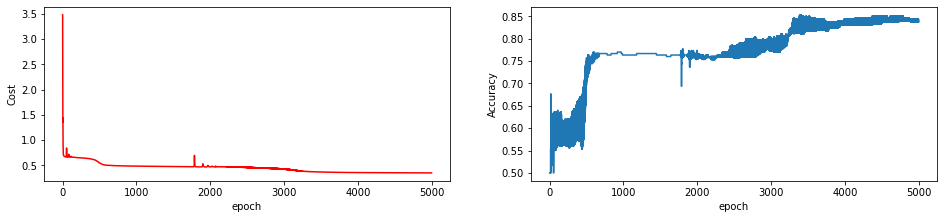

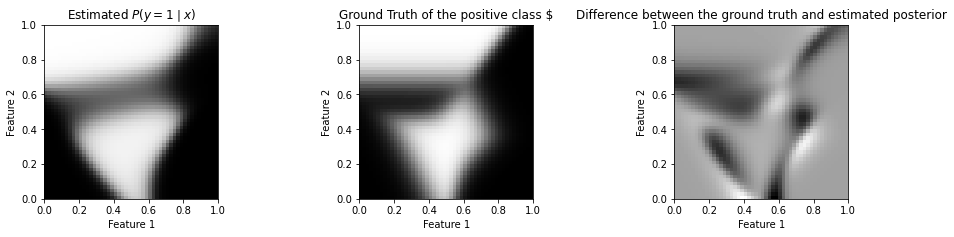

In [23]:
# We get the cost and accuracy during training 
# by referencing the nnet object's attributes costs and accuracies which we give to the visualization function
losses_training = nnet.losses
accuracy_training = nnet.accuracies
visualize_cost_accuracy_curves(accuracy_training, losses_training)
# we give the nnet object to the second visualization function to visualize the estimated posterior
visualize_posterior(nnet)

<a id='Train2'></a>
## Train a network with ReLU activation functions.
Define a new network with the same number of nodes and name it nnet_2 in order to avoid erasing the previous model. Once the training is completed visualize the cost / accuracy curves and the estimated posterior using the provided code. 

In [24]:
nnodes = [2, 10, 10, 2]
learning_rate = 0.2
epochs = 5000 
############ TO DO Q2d ############################
activation_functions = 'relu' # this can either be 'sigmoid' or 'relu'
nnet_2 = NeuralNetwork(nnodes, activation_functions) # creating a NeuralNetwork instance
# accessing the weights attribute of the nnet instance we can print weight shapes per layer
print(['layer {}: w {}'.format(layer, w.shape) for w, layer in zip(nnet.weights, range(len(nnet.weights)))]) 
nnet_2.gradient_descent(train_data, epochs, learning_rate, test_data)
###########  TO DO Q2d ###########################

['layer 0: w (10, 2)', 'layer 1: w (10, 10)', 'layer 2: w (2, 10)']
Epoch 0: Accuracy 150 / 300 loss: 3.9904283688354862
Epoch 1: Accuracy 167 / 300 loss: 0.8386755655947118
Epoch 2: Accuracy 167 / 300 loss: 0.7916380197596271
Epoch 3: Accuracy 166 / 300 loss: 0.7566042796220939
Epoch 4: Accuracy 174 / 300 loss: 0.7316889658682839
Epoch 5: Accuracy 162 / 300 loss: 0.7124499355662152
Epoch 6: Accuracy 176 / 300 loss: 0.6971245120505175
Epoch 7: Accuracy 165 / 300 loss: 0.6846449716351412
Epoch 8: Accuracy 169 / 300 loss: 0.674095478784333
Epoch 9: Accuracy 170 / 300 loss: 0.6650088975393323
Epoch 10: Accuracy 167 / 300 loss: 0.6570642437309449
Epoch 11: Accuracy 180 / 300 loss: 0.6502626510047745
Epoch 12: Accuracy 183 / 300 loss: 0.6442447055448115
Epoch 13: Accuracy 185 / 300 loss: 0.6387913997876699
Epoch 14: Accuracy 188 / 300 loss: 0.6341020694643268
Epoch 15: Accuracy 192 / 300 loss: 0.6298964647306748
Epoch 16: Accuracy 193 / 300 loss: 0.6260620495165959
Epoch 17: Accuracy 202 / 

Epoch 152: Accuracy 200 / 300 loss: 0.5608424159645659
Epoch 153: Accuracy 223 / 300 loss: 0.5657476869951449
Epoch 154: Accuracy 200 / 300 loss: 0.5570763921816948
Epoch 155: Accuracy 222 / 300 loss: 0.5617635950521855
Epoch 156: Accuracy 199 / 300 loss: 0.5547696265574875
Epoch 157: Accuracy 222 / 300 loss: 0.5598894142452057
Epoch 158: Accuracy 202 / 300 loss: 0.5518313404347281
Epoch 159: Accuracy 222 / 300 loss: 0.5564405266313547
Epoch 160: Accuracy 203 / 300 loss: 0.5500683556106015
Epoch 161: Accuracy 221 / 300 loss: 0.5550628194076122
Epoch 162: Accuracy 205 / 300 loss: 0.548725318599549
Epoch 163: Accuracy 222 / 300 loss: 0.5531859475447634
Epoch 164: Accuracy 207 / 300 loss: 0.5474260785252788
Epoch 165: Accuracy 222 / 300 loss: 0.5515284536925165
Epoch 166: Accuracy 208 / 300 loss: 0.5460723488274591
Epoch 167: Accuracy 221 / 300 loss: 0.5500811478785821
Epoch 168: Accuracy 206 / 300 loss: 0.5449134652143225
Epoch 169: Accuracy 223 / 300 loss: 0.5486897747490032
Epoch 170: 

Epoch 303: Accuracy 223 / 300 loss: 0.510956818767212
Epoch 304: Accuracy 217 / 300 loss: 0.5019550984926628
Epoch 305: Accuracy 224 / 300 loss: 0.5109541668361652
Epoch 306: Accuracy 217 / 300 loss: 0.501643898093956
Epoch 307: Accuracy 225 / 300 loss: 0.5107134481909616
Epoch 308: Accuracy 217 / 300 loss: 0.501760331004134
Epoch 309: Accuracy 224 / 300 loss: 0.5103072851983339
Epoch 310: Accuracy 218 / 300 loss: 0.5011320296449928
Epoch 311: Accuracy 224 / 300 loss: 0.5094454428587747
Epoch 312: Accuracy 219 / 300 loss: 0.5006190962516803
Epoch 313: Accuracy 224 / 300 loss: 0.5089518879091184
Epoch 314: Accuracy 221 / 300 loss: 0.49986104214287524
Epoch 315: Accuracy 224 / 300 loss: 0.5091420746271789
Epoch 316: Accuracy 224 / 300 loss: 0.49800878315204045
Epoch 317: Accuracy 224 / 300 loss: 0.505369161179508
Epoch 318: Accuracy 222 / 300 loss: 0.49565753494545606
Epoch 319: Accuracy 227 / 300 loss: 0.5016567659238815
Epoch 320: Accuracy 224 / 300 loss: 0.4967692025418236
Epoch 321: 

Epoch 452: Accuracy 230 / 300 loss: 0.4775256337442795
Epoch 453: Accuracy 224 / 300 loss: 0.4924996219849094
Epoch 454: Accuracy 232 / 300 loss: 0.4785582140975123
Epoch 455: Accuracy 224 / 300 loss: 0.4921458306133052
Epoch 456: Accuracy 232 / 300 loss: 0.477192777626162
Epoch 457: Accuracy 224 / 300 loss: 0.4900385403041716
Epoch 458: Accuracy 232 / 300 loss: 0.4760050456163885
Epoch 459: Accuracy 225 / 300 loss: 0.48880940625813574
Epoch 460: Accuracy 233 / 300 loss: 0.47522911219654174
Epoch 461: Accuracy 226 / 300 loss: 0.4881522198731862
Epoch 462: Accuracy 233 / 300 loss: 0.4747579516903994
Epoch 463: Accuracy 226 / 300 loss: 0.48792324541313037
Epoch 464: Accuracy 233 / 300 loss: 0.47438494757323535
Epoch 465: Accuracy 226 / 300 loss: 0.4877149238778378
Epoch 466: Accuracy 233 / 300 loss: 0.4741278153071511
Epoch 467: Accuracy 226 / 300 loss: 0.48778025749651893
Epoch 468: Accuracy 231 / 300 loss: 0.475561746042739
Epoch 469: Accuracy 224 / 300 loss: 0.4914190899176547
Epoch 4

Epoch 607: Accuracy 223 / 300 loss: 0.4902769653288766
Epoch 608: Accuracy 234 / 300 loss: 0.46796009401219757
Epoch 609: Accuracy 223 / 300 loss: 0.4884874319647801
Epoch 610: Accuracy 234 / 300 loss: 0.4686838330933849
Epoch 611: Accuracy 223 / 300 loss: 0.48989999883015334
Epoch 612: Accuracy 235 / 300 loss: 0.4675792481906681
Epoch 613: Accuracy 223 / 300 loss: 0.48788053336368636
Epoch 614: Accuracy 233 / 300 loss: 0.46995457386950923
Epoch 615: Accuracy 223 / 300 loss: 0.4928934930691463
Epoch 616: Accuracy 234 / 300 loss: 0.46697590812774553
Epoch 617: Accuracy 224 / 300 loss: 0.4848447055596473
Epoch 618: Accuracy 233 / 300 loss: 0.4680827834856791
Epoch 619: Accuracy 223 / 300 loss: 0.48844274973368007
Epoch 620: Accuracy 235 / 300 loss: 0.4663598834924167
Epoch 621: Accuracy 224 / 300 loss: 0.48465632763607847
Epoch 622: Accuracy 235 / 300 loss: 0.4680288183559634
Epoch 623: Accuracy 223 / 300 loss: 0.48774419543698067
Epoch 624: Accuracy 234 / 300 loss: 0.4677520090952506
Ep

Epoch 758: Accuracy 241 / 300 loss: 0.4488323081431617
Epoch 759: Accuracy 231 / 300 loss: 0.4590526736639097
Epoch 760: Accuracy 242 / 300 loss: 0.44893070991362977
Epoch 761: Accuracy 231 / 300 loss: 0.4603373835271259
Epoch 762: Accuracy 242 / 300 loss: 0.45127981223009556
Epoch 763: Accuracy 231 / 300 loss: 0.4636456872096856
Epoch 764: Accuracy 242 / 300 loss: 0.4526131060614506
Epoch 765: Accuracy 229 / 300 loss: 0.4655272828417075
Epoch 766: Accuracy 243 / 300 loss: 0.45397951347542914
Epoch 767: Accuracy 229 / 300 loss: 0.46760110303358365
Epoch 768: Accuracy 243 / 300 loss: 0.455165444467409
Epoch 769: Accuracy 229 / 300 loss: 0.46922713255702947
Epoch 770: Accuracy 243 / 300 loss: 0.4567400043058876
Epoch 771: Accuracy 228 / 300 loss: 0.47141383808387505
Epoch 772: Accuracy 242 / 300 loss: 0.4564089917026902
Epoch 773: Accuracy 230 / 300 loss: 0.46920231585884814
Epoch 774: Accuracy 243 / 300 loss: 0.45583801510338323
Epoch 775: Accuracy 230 / 300 loss: 0.4683574493086431
Epo

Epoch 912: Accuracy 242 / 300 loss: 0.44231818556561564
Epoch 913: Accuracy 234 / 300 loss: 0.4511878132116304
Epoch 914: Accuracy 243 / 300 loss: 0.4450552229715903
Epoch 915: Accuracy 231 / 300 loss: 0.4536527030315002
Epoch 916: Accuracy 243 / 300 loss: 0.4454343402016764
Epoch 917: Accuracy 231 / 300 loss: 0.4554264414359135
Epoch 918: Accuracy 243 / 300 loss: 0.4476547645916894
Epoch 919: Accuracy 230 / 300 loss: 0.45690522601102335
Epoch 920: Accuracy 243 / 300 loss: 0.4475815565544687
Epoch 921: Accuracy 231 / 300 loss: 0.4542040747258099
Epoch 922: Accuracy 243 / 300 loss: 0.4461241597225316
Epoch 923: Accuracy 232 / 300 loss: 0.4518695864544173
Epoch 924: Accuracy 243 / 300 loss: 0.4450231615906507
Epoch 925: Accuracy 233 / 300 loss: 0.4500942056161124
Epoch 926: Accuracy 243 / 300 loss: 0.44227479101615746
Epoch 927: Accuracy 236 / 300 loss: 0.4473372323907151
Epoch 928: Accuracy 243 / 300 loss: 0.4404940598844871
Epoch 929: Accuracy 236 / 300 loss: 0.4446505230468882
Epoch 9

Epoch 1067: Accuracy 235 / 300 loss: 0.4437251831025778
Epoch 1068: Accuracy 242 / 300 loss: 0.4357979038108069
Epoch 1069: Accuracy 236 / 300 loss: 0.44079258968383156
Epoch 1070: Accuracy 242 / 300 loss: 0.4349823185663006
Epoch 1071: Accuracy 236 / 300 loss: 0.4416695458908398
Epoch 1072: Accuracy 241 / 300 loss: 0.4315586748533653
Epoch 1073: Accuracy 238 / 300 loss: 0.4365284099079846
Epoch 1074: Accuracy 240 / 300 loss: 0.4310304949526113
Epoch 1075: Accuracy 238 / 300 loss: 0.4360423686295176
Epoch 1076: Accuracy 240 / 300 loss: 0.43004248347688495
Epoch 1077: Accuracy 239 / 300 loss: 0.43491965225267487
Epoch 1078: Accuracy 240 / 300 loss: 0.4284174013562689
Epoch 1079: Accuracy 239 / 300 loss: 0.43100456254425057
Epoch 1080: Accuracy 240 / 300 loss: 0.4267338488545525
Epoch 1081: Accuracy 240 / 300 loss: 0.4305596689449486
Epoch 1082: Accuracy 238 / 300 loss: 0.4249146385821096
Epoch 1083: Accuracy 242 / 300 loss: 0.4265772104253935
Epoch 1084: Accuracy 239 / 300 loss: 0.42283

Epoch 1216: Accuracy 239 / 300 loss: 0.4247563686831366
Epoch 1217: Accuracy 240 / 300 loss: 0.4306242248379221
Epoch 1218: Accuracy 239 / 300 loss: 0.42440538905140535
Epoch 1219: Accuracy 241 / 300 loss: 0.42975748207769054
Epoch 1220: Accuracy 239 / 300 loss: 0.4237806849175132
Epoch 1221: Accuracy 239 / 300 loss: 0.432757371488116
Epoch 1222: Accuracy 239 / 300 loss: 0.42614039157880773
Epoch 1223: Accuracy 239 / 300 loss: 0.4359348915968124
Epoch 1224: Accuracy 240 / 300 loss: 0.428556630511389
Epoch 1225: Accuracy 239 / 300 loss: 0.43532104482563805
Epoch 1226: Accuracy 240 / 300 loss: 0.4286781482407857
Epoch 1227: Accuracy 239 / 300 loss: 0.4354857479053978
Epoch 1228: Accuracy 239 / 300 loss: 0.4286602366306759
Epoch 1229: Accuracy 239 / 300 loss: 0.4320027116575518
Epoch 1230: Accuracy 239 / 300 loss: 0.4244995523591214
Epoch 1231: Accuracy 240 / 300 loss: 0.43249739556641564
Epoch 1232: Accuracy 240 / 300 loss: 0.42601937595953565
Epoch 1233: Accuracy 239 / 300 loss: 0.43555

Epoch 1368: Accuracy 244 / 300 loss: 0.40642076919883
Epoch 1369: Accuracy 245 / 300 loss: 0.4086861986268688
Epoch 1370: Accuracy 244 / 300 loss: 0.40866171355575936
Epoch 1371: Accuracy 247 / 300 loss: 0.41098888542519213
Epoch 1372: Accuracy 244 / 300 loss: 0.4117202272571653
Epoch 1373: Accuracy 245 / 300 loss: 0.4141253487041814
Epoch 1374: Accuracy 245 / 300 loss: 0.4159478579562961
Epoch 1375: Accuracy 245 / 300 loss: 0.42123618192185086
Epoch 1376: Accuracy 240 / 300 loss: 0.42489978484612784
Epoch 1377: Accuracy 241 / 300 loss: 0.4341980985772859
Epoch 1378: Accuracy 241 / 300 loss: 0.4306422116981332
Epoch 1379: Accuracy 235 / 300 loss: 0.44395620400368224
Epoch 1380: Accuracy 243 / 300 loss: 0.4366661022613843
Epoch 1381: Accuracy 236 / 300 loss: 0.4519172392627033
Epoch 1382: Accuracy 243 / 300 loss: 0.4408980407579656
Epoch 1383: Accuracy 236 / 300 loss: 0.45642336157891844
Epoch 1384: Accuracy 243 / 300 loss: 0.43583266766730216
Epoch 1385: Accuracy 237 / 300 loss: 0.4458

Epoch 1515: Accuracy 235 / 300 loss: 0.4454611685584433
Epoch 1516: Accuracy 244 / 300 loss: 0.43402127404874286
Epoch 1517: Accuracy 235 / 300 loss: 0.4468511081074621
Epoch 1518: Accuracy 244 / 300 loss: 0.43551318150955626
Epoch 1519: Accuracy 236 / 300 loss: 0.44880744135771644
Epoch 1520: Accuracy 242 / 300 loss: 0.43753558272516985
Epoch 1521: Accuracy 236 / 300 loss: 0.44894013046622755
Epoch 1522: Accuracy 242 / 300 loss: 0.4349777663029865
Epoch 1523: Accuracy 236 / 300 loss: 0.44361148510617776
Epoch 1524: Accuracy 241 / 300 loss: 0.4275943025055226
Epoch 1525: Accuracy 245 / 300 loss: 0.4285898310332515
Epoch 1526: Accuracy 243 / 300 loss: 0.4211234116139388
Epoch 1527: Accuracy 246 / 300 loss: 0.4189566961409895
Epoch 1528: Accuracy 246 / 300 loss: 0.4156340352441842
Epoch 1529: Accuracy 247 / 300 loss: 0.4136172922182521
Epoch 1530: Accuracy 247 / 300 loss: 0.41354893608450277
Epoch 1531: Accuracy 247 / 300 loss: 0.4113272108273538
Epoch 1532: Accuracy 246 / 300 loss: 0.41

Epoch 1667: Accuracy 247 / 300 loss: 0.4080112961166673
Epoch 1668: Accuracy 247 / 300 loss: 0.40960370757801395
Epoch 1669: Accuracy 248 / 300 loss: 0.40930775210533926
Epoch 1670: Accuracy 247 / 300 loss: 0.4108192839225425
Epoch 1671: Accuracy 248 / 300 loss: 0.41073764127699697
Epoch 1672: Accuracy 247 / 300 loss: 0.41211639358787583
Epoch 1673: Accuracy 249 / 300 loss: 0.4122622834296696
Epoch 1674: Accuracy 247 / 300 loss: 0.4138531268130582
Epoch 1675: Accuracy 247 / 300 loss: 0.4149283844024387
Epoch 1676: Accuracy 247 / 300 loss: 0.4160354355097752
Epoch 1677: Accuracy 247 / 300 loss: 0.4169789267628579
Epoch 1678: Accuracy 246 / 300 loss: 0.41762222711894514
Epoch 1679: Accuracy 246 / 300 loss: 0.4187263491479657
Epoch 1680: Accuracy 247 / 300 loss: 0.4165407842017631
Epoch 1681: Accuracy 247 / 300 loss: 0.41691190521053795
Epoch 1682: Accuracy 247 / 300 loss: 0.4173139137580426
Epoch 1683: Accuracy 247 / 300 loss: 0.41770537645599587
Epoch 1684: Accuracy 246 / 300 loss: 0.41

Epoch 1814: Accuracy 243 / 300 loss: 0.39869628675434626
Epoch 1815: Accuracy 246 / 300 loss: 0.3987943351480095
Epoch 1816: Accuracy 244 / 300 loss: 0.4005161864371951
Epoch 1817: Accuracy 248 / 300 loss: 0.39966724844024837
Epoch 1818: Accuracy 244 / 300 loss: 0.40129748291250117
Epoch 1819: Accuracy 247 / 300 loss: 0.40075456047699376
Epoch 1820: Accuracy 245 / 300 loss: 0.4017532343682539
Epoch 1821: Accuracy 247 / 300 loss: 0.40052389653041137
Epoch 1822: Accuracy 245 / 300 loss: 0.40172519598336326
Epoch 1823: Accuracy 247 / 300 loss: 0.40085851440316944
Epoch 1824: Accuracy 245 / 300 loss: 0.4021037420175299
Epoch 1825: Accuracy 247 / 300 loss: 0.4017084926853749
Epoch 1826: Accuracy 245 / 300 loss: 0.40247914458632916
Epoch 1827: Accuracy 247 / 300 loss: 0.40257541831441107
Epoch 1828: Accuracy 246 / 300 loss: 0.40280113340158813
Epoch 1829: Accuracy 247 / 300 loss: 0.4028338622180286
Epoch 1830: Accuracy 247 / 300 loss: 0.4042156392269426
Epoch 1831: Accuracy 247 / 300 loss: 0

Epoch 1963: Accuracy 247 / 300 loss: 0.4001992986126235
Epoch 1964: Accuracy 245 / 300 loss: 0.4008561671325881
Epoch 1965: Accuracy 247 / 300 loss: 0.40003492867635404
Epoch 1966: Accuracy 245 / 300 loss: 0.400513852050827
Epoch 1967: Accuracy 247 / 300 loss: 0.3996558900699399
Epoch 1968: Accuracy 245 / 300 loss: 0.39966006491163614
Epoch 1969: Accuracy 247 / 300 loss: 0.3984884325120451
Epoch 1970: Accuracy 244 / 300 loss: 0.39747679676509234
Epoch 1971: Accuracy 244 / 300 loss: 0.3967228951697766
Epoch 1972: Accuracy 244 / 300 loss: 0.3974339804202631
Epoch 1973: Accuracy 245 / 300 loss: 0.3971634926528718
Epoch 1974: Accuracy 244 / 300 loss: 0.3989865241954349
Epoch 1975: Accuracy 247 / 300 loss: 0.39882130562554324
Epoch 1976: Accuracy 246 / 300 loss: 0.4001909859781587
Epoch 1977: Accuracy 247 / 300 loss: 0.39924261650670984
Epoch 1978: Accuracy 245 / 300 loss: 0.4004594618424109
Epoch 1979: Accuracy 247 / 300 loss: 0.3994373889124876
Epoch 1980: Accuracy 245 / 300 loss: 0.40013

Epoch 2109: Accuracy 245 / 300 loss: 0.3941752370346216
Epoch 2110: Accuracy 244 / 300 loss: 0.3957453206035514
Epoch 2111: Accuracy 245 / 300 loss: 0.39502498775451694
Epoch 2112: Accuracy 244 / 300 loss: 0.3965997095831082
Epoch 2113: Accuracy 247 / 300 loss: 0.39518252920330205
Epoch 2114: Accuracy 244 / 300 loss: 0.39754330782083547
Epoch 2115: Accuracy 247 / 300 loss: 0.3965847285757143
Epoch 2116: Accuracy 245 / 300 loss: 0.39919979891010726
Epoch 2117: Accuracy 247 / 300 loss: 0.3986577126243207
Epoch 2118: Accuracy 247 / 300 loss: 0.4025607960056498
Epoch 2119: Accuracy 247 / 300 loss: 0.3999313243576034
Epoch 2120: Accuracy 247 / 300 loss: 0.40355586978909663
Epoch 2121: Accuracy 247 / 300 loss: 0.40116431768365
Epoch 2122: Accuracy 248 / 300 loss: 0.4045819845099039
Epoch 2123: Accuracy 247 / 300 loss: 0.4022608906623293
Epoch 2124: Accuracy 248 / 300 loss: 0.40337706727700834
Epoch 2125: Accuracy 247 / 300 loss: 0.4017127648088086
Epoch 2126: Accuracy 248 / 300 loss: 0.40382

Epoch 2259: Accuracy 246 / 300 loss: 0.4123658141721888
Epoch 2260: Accuracy 245 / 300 loss: 0.4135336168192415
Epoch 2261: Accuracy 247 / 300 loss: 0.4118106798220334
Epoch 2262: Accuracy 245 / 300 loss: 0.4129515919931356
Epoch 2263: Accuracy 247 / 300 loss: 0.4102743974631429
Epoch 2264: Accuracy 246 / 300 loss: 0.41107125593400434
Epoch 2265: Accuracy 247 / 300 loss: 0.40890802300561946
Epoch 2266: Accuracy 246 / 300 loss: 0.4093774952554079
Epoch 2267: Accuracy 247 / 300 loss: 0.404944537423135
Epoch 2268: Accuracy 249 / 300 loss: 0.40554685933945095
Epoch 2269: Accuracy 246 / 300 loss: 0.4006857589167346
Epoch 2270: Accuracy 250 / 300 loss: 0.4005090893955877
Epoch 2271: Accuracy 244 / 300 loss: 0.3967266012501399
Epoch 2272: Accuracy 249 / 300 loss: 0.39727601221874703
Epoch 2273: Accuracy 244 / 300 loss: 0.39737633619296464
Epoch 2274: Accuracy 250 / 300 loss: 0.39972345742858273
Epoch 2275: Accuracy 243 / 300 loss: 0.39589000434230065
Epoch 2276: Accuracy 249 / 300 loss: 0.396

Epoch 2408: Accuracy 246 / 300 loss: 0.4016051674251774
Epoch 2409: Accuracy 247 / 300 loss: 0.40074667600419545
Epoch 2410: Accuracy 246 / 300 loss: 0.40361408439773716
Epoch 2411: Accuracy 247 / 300 loss: 0.39976352934051396
Epoch 2412: Accuracy 246 / 300 loss: 0.4015025228687922
Epoch 2413: Accuracy 247 / 300 loss: 0.399472711134334
Epoch 2414: Accuracy 246 / 300 loss: 0.40173792429528093
Epoch 2415: Accuracy 247 / 300 loss: 0.4003349946302353
Epoch 2416: Accuracy 248 / 300 loss: 0.40250735039133756
Epoch 2417: Accuracy 247 / 300 loss: 0.4010344398564557
Epoch 2418: Accuracy 246 / 300 loss: 0.40490951922687607
Epoch 2419: Accuracy 248 / 300 loss: 0.40404757558074417
Epoch 2420: Accuracy 246 / 300 loss: 0.4084617022381876
Epoch 2421: Accuracy 247 / 300 loss: 0.40592587403890895
Epoch 2422: Accuracy 247 / 300 loss: 0.40819628479172854
Epoch 2423: Accuracy 246 / 300 loss: 0.40434690010287316
Epoch 2424: Accuracy 246 / 300 loss: 0.4064605242410721
Epoch 2425: Accuracy 247 / 300 loss: 0.

Epoch 2554: Accuracy 244 / 300 loss: 0.39732115128633383
Epoch 2555: Accuracy 248 / 300 loss: 0.3947453063182563
Epoch 2556: Accuracy 244 / 300 loss: 0.39728983946348445
Epoch 2557: Accuracy 248 / 300 loss: 0.3937300348075676
Epoch 2558: Accuracy 247 / 300 loss: 0.39448699148190913
Epoch 2559: Accuracy 248 / 300 loss: 0.3946128148303312
Epoch 2560: Accuracy 247 / 300 loss: 0.3961195955206267
Epoch 2561: Accuracy 248 / 300 loss: 0.39643673608230817
Epoch 2562: Accuracy 245 / 300 loss: 0.39914918661124216
Epoch 2563: Accuracy 248 / 300 loss: 0.3954608805474621
Epoch 2564: Accuracy 247 / 300 loss: 0.39618824795995816
Epoch 2565: Accuracy 248 / 300 loss: 0.39628258340307754
Epoch 2566: Accuracy 246 / 300 loss: 0.39928537679692483
Epoch 2567: Accuracy 248 / 300 loss: 0.39662396142712336
Epoch 2568: Accuracy 246 / 300 loss: 0.39971043885821717
Epoch 2569: Accuracy 248 / 300 loss: 0.39770906555675284
Epoch 2570: Accuracy 248 / 300 loss: 0.4003826407121201
Epoch 2571: Accuracy 245 / 300 loss: 

Epoch 2704: Accuracy 243 / 300 loss: 0.410334192611627
Epoch 2705: Accuracy 247 / 300 loss: 0.4080786755022411
Epoch 2706: Accuracy 243 / 300 loss: 0.41188076849363464
Epoch 2707: Accuracy 247 / 300 loss: 0.4098477111884258
Epoch 2708: Accuracy 243 / 300 loss: 0.4122533681479983
Epoch 2709: Accuracy 248 / 300 loss: 0.40836092124114637
Epoch 2710: Accuracy 242 / 300 loss: 0.4086129874345149
Epoch 2711: Accuracy 250 / 300 loss: 0.40758468064679576
Epoch 2712: Accuracy 242 / 300 loss: 0.4080088465373594
Epoch 2713: Accuracy 249 / 300 loss: 0.40698420167246385
Epoch 2714: Accuracy 243 / 300 loss: 0.4087774725101531
Epoch 2715: Accuracy 248 / 300 loss: 0.406486373437508
Epoch 2716: Accuracy 243 / 300 loss: 0.408103615521722
Epoch 2717: Accuracy 248 / 300 loss: 0.4050201828688774
Epoch 2718: Accuracy 242 / 300 loss: 0.40516806812483797
Epoch 2719: Accuracy 247 / 300 loss: 0.40368707600035036
Epoch 2720: Accuracy 242 / 300 loss: 0.4046444004712175
Epoch 2721: Accuracy 248 / 300 loss: 0.402173

Epoch 2859: Accuracy 247 / 300 loss: 0.3973757778468834
Epoch 2860: Accuracy 246 / 300 loss: 0.3980355448434379
Epoch 2861: Accuracy 247 / 300 loss: 0.3989027985545781
Epoch 2862: Accuracy 247 / 300 loss: 0.39884090349298523
Epoch 2863: Accuracy 247 / 300 loss: 0.39893548697869474
Epoch 2864: Accuracy 247 / 300 loss: 0.39943204041845465
Epoch 2865: Accuracy 246 / 300 loss: 0.4001516919030397
Epoch 2866: Accuracy 248 / 300 loss: 0.39992567238836585
Epoch 2867: Accuracy 246 / 300 loss: 0.40155208692674815
Epoch 2868: Accuracy 246 / 300 loss: 0.40228571115624784
Epoch 2869: Accuracy 246 / 300 loss: 0.40278839491590823
Epoch 2870: Accuracy 246 / 300 loss: 0.4034642214203302
Epoch 2871: Accuracy 247 / 300 loss: 0.4043389061171211
Epoch 2872: Accuracy 247 / 300 loss: 0.40587405417167377
Epoch 2873: Accuracy 245 / 300 loss: 0.40677748239176525
Epoch 2874: Accuracy 248 / 300 loss: 0.4073408347728564
Epoch 2875: Accuracy 245 / 300 loss: 0.4073698495722826
Epoch 2876: Accuracy 247 / 300 loss: 0.

Epoch 3010: Accuracy 245 / 300 loss: 0.3945425477951372
Epoch 3011: Accuracy 252 / 300 loss: 0.3930317570605858
Epoch 3012: Accuracy 243 / 300 loss: 0.39575865438761504
Epoch 3013: Accuracy 251 / 300 loss: 0.39489841613181254
Epoch 3014: Accuracy 242 / 300 loss: 0.397543867077434
Epoch 3015: Accuracy 248 / 300 loss: 0.4011162505076815
Epoch 3016: Accuracy 244 / 300 loss: 0.40880334729820156
Epoch 3017: Accuracy 248 / 300 loss: 0.4055309639369681
Epoch 3018: Accuracy 243 / 300 loss: 0.41601952918624446
Epoch 3019: Accuracy 246 / 300 loss: 0.4150426032029453
Epoch 3020: Accuracy 241 / 300 loss: 0.42945482913783956
Epoch 3021: Accuracy 239 / 300 loss: 0.4279681455482874
Epoch 3022: Accuracy 240 / 300 loss: 0.43704668589308243
Epoch 3023: Accuracy 242 / 300 loss: 0.42706910424065825
Epoch 3024: Accuracy 241 / 300 loss: 0.43247361759381087
Epoch 3025: Accuracy 246 / 300 loss: 0.4227194178200048
Epoch 3026: Accuracy 240 / 300 loss: 0.4250543329175358
Epoch 3027: Accuracy 248 / 300 loss: 0.41

Epoch 3162: Accuracy 252 / 300 loss: 0.388609129805816
Epoch 3163: Accuracy 242 / 300 loss: 0.3893668349479489
Epoch 3164: Accuracy 251 / 300 loss: 0.3878166236278201
Epoch 3165: Accuracy 244 / 300 loss: 0.38773811469460345
Epoch 3166: Accuracy 250 / 300 loss: 0.3879385276837355
Epoch 3167: Accuracy 244 / 300 loss: 0.38773986714819253
Epoch 3168: Accuracy 250 / 300 loss: 0.3881083389507497
Epoch 3169: Accuracy 243 / 300 loss: 0.3886865351774732
Epoch 3170: Accuracy 250 / 300 loss: 0.38913890560620196
Epoch 3171: Accuracy 241 / 300 loss: 0.39375764411723085
Epoch 3172: Accuracy 252 / 300 loss: 0.3901271626703583
Epoch 3173: Accuracy 245 / 300 loss: 0.39292857540040166
Epoch 3174: Accuracy 252 / 300 loss: 0.3906416976665343
Epoch 3175: Accuracy 244 / 300 loss: 0.3916567885539789
Epoch 3176: Accuracy 250 / 300 loss: 0.38991882489916524
Epoch 3177: Accuracy 243 / 300 loss: 0.39038142110729357
Epoch 3178: Accuracy 251 / 300 loss: 0.39065507890942697
Epoch 3179: Accuracy 244 / 300 loss: 0.39

Epoch 3311: Accuracy 244 / 300 loss: 0.38895149369425097
Epoch 3312: Accuracy 251 / 300 loss: 0.3887442513395413
Epoch 3313: Accuracy 243 / 300 loss: 0.390977041468594
Epoch 3314: Accuracy 250 / 300 loss: 0.38736992136247944
Epoch 3315: Accuracy 246 / 300 loss: 0.3872893222204209
Epoch 3316: Accuracy 251 / 300 loss: 0.3875356247758644
Epoch 3317: Accuracy 244 / 300 loss: 0.3879235048976302
Epoch 3318: Accuracy 251 / 300 loss: 0.3883561643422643
Epoch 3319: Accuracy 242 / 300 loss: 0.3894201766784985
Epoch 3320: Accuracy 251 / 300 loss: 0.38753143661458045
Epoch 3321: Accuracy 244 / 300 loss: 0.38800628778528523
Epoch 3322: Accuracy 251 / 300 loss: 0.3884240259461509
Epoch 3323: Accuracy 242 / 300 loss: 0.3896258935312141
Epoch 3324: Accuracy 251 / 300 loss: 0.3877346399592494
Epoch 3325: Accuracy 243 / 300 loss: 0.3882224536473094
Epoch 3326: Accuracy 251 / 300 loss: 0.3886113344174721
Epoch 3327: Accuracy 243 / 300 loss: 0.38989145916063445
Epoch 3328: Accuracy 251 / 300 loss: 0.38752

Epoch 3461: Accuracy 242 / 300 loss: 0.38949638552606697
Epoch 3462: Accuracy 251 / 300 loss: 0.3878151167463761
Epoch 3463: Accuracy 243 / 300 loss: 0.3884143388667371
Epoch 3464: Accuracy 251 / 300 loss: 0.3885341769885976
Epoch 3465: Accuracy 241 / 300 loss: 0.39176994467855925
Epoch 3466: Accuracy 252 / 300 loss: 0.38781942397599556
Epoch 3467: Accuracy 242 / 300 loss: 0.38847418349176177
Epoch 3468: Accuracy 251 / 300 loss: 0.3880725562401589
Epoch 3469: Accuracy 243 / 300 loss: 0.3886746635077475
Epoch 3470: Accuracy 251 / 300 loss: 0.38797392325944036
Epoch 3471: Accuracy 242 / 300 loss: 0.38884675491511267
Epoch 3472: Accuracy 251 / 300 loss: 0.3875537057715908
Epoch 3473: Accuracy 242 / 300 loss: 0.3880936447067406
Epoch 3474: Accuracy 251 / 300 loss: 0.38861375987687397
Epoch 3475: Accuracy 241 / 300 loss: 0.3925973061845337
Epoch 3476: Accuracy 251 / 300 loss: 0.3886110133453469
Epoch 3477: Accuracy 244 / 300 loss: 0.389520507585532
Epoch 3478: Accuracy 251 / 300 loss: 0.388

Epoch 3609: Accuracy 241 / 300 loss: 0.39106089533404853
Epoch 3610: Accuracy 251 / 300 loss: 0.38753110965172094
Epoch 3611: Accuracy 243 / 300 loss: 0.38824035713392635
Epoch 3612: Accuracy 251 / 300 loss: 0.3876970599747679
Epoch 3613: Accuracy 243 / 300 loss: 0.3884424058940533
Epoch 3614: Accuracy 251 / 300 loss: 0.3885275051812338
Epoch 3615: Accuracy 241 / 300 loss: 0.3917916133526692
Epoch 3616: Accuracy 251 / 300 loss: 0.38749208718428513
Epoch 3617: Accuracy 243 / 300 loss: 0.3882879034451491
Epoch 3618: Accuracy 251 / 300 loss: 0.38778236046792997
Epoch 3619: Accuracy 243 / 300 loss: 0.388530008934951
Epoch 3620: Accuracy 251 / 300 loss: 0.3874968333293921
Epoch 3621: Accuracy 244 / 300 loss: 0.38754678576289336
Epoch 3622: Accuracy 251 / 300 loss: 0.3879797881733843
Epoch 3623: Accuracy 242 / 300 loss: 0.38929252390893715
Epoch 3624: Accuracy 251 / 300 loss: 0.3871045660391925
Epoch 3625: Accuracy 244 / 300 loss: 0.38737226319052304
Epoch 3626: Accuracy 251 / 300 loss: 0.38

Epoch 3757: Accuracy 246 / 300 loss: 0.38546982602267105
Epoch 3758: Accuracy 248 / 300 loss: 0.38535227507897624
Epoch 3759: Accuracy 246 / 300 loss: 0.3854286674871828
Epoch 3760: Accuracy 249 / 300 loss: 0.3854715514373586
Epoch 3761: Accuracy 247 / 300 loss: 0.3854855654739316
Epoch 3762: Accuracy 249 / 300 loss: 0.3855665273969752
Epoch 3763: Accuracy 247 / 300 loss: 0.38560408633594473
Epoch 3764: Accuracy 249 / 300 loss: 0.385637155432488
Epoch 3765: Accuracy 247 / 300 loss: 0.38573526195952007
Epoch 3766: Accuracy 249 / 300 loss: 0.3861574825848704
Epoch 3767: Accuracy 247 / 300 loss: 0.3876946194833994
Epoch 3768: Accuracy 250 / 300 loss: 0.3878324016800646
Epoch 3769: Accuracy 245 / 300 loss: 0.3908447259791766
Epoch 3770: Accuracy 251 / 300 loss: 0.38718716679509524
Epoch 3771: Accuracy 246 / 300 loss: 0.38802551602893587
Epoch 3772: Accuracy 251 / 300 loss: 0.38676547426925695
Epoch 3773: Accuracy 245 / 300 loss: 0.3869539649449902
Epoch 3774: Accuracy 251 / 300 loss: 0.386

Epoch 3908: Accuracy 252 / 300 loss: 0.38675148582557045
Epoch 3909: Accuracy 245 / 300 loss: 0.386605030037635
Epoch 3910: Accuracy 251 / 300 loss: 0.38685449334979743
Epoch 3911: Accuracy 243 / 300 loss: 0.38751728968580085
Epoch 3912: Accuracy 251 / 300 loss: 0.3879772407823464
Epoch 3913: Accuracy 242 / 300 loss: 0.3909456922522083
Epoch 3914: Accuracy 252 / 300 loss: 0.38766484962921893
Epoch 3915: Accuracy 243 / 300 loss: 0.3884864396866103
Epoch 3916: Accuracy 251 / 300 loss: 0.3873912099865594
Epoch 3917: Accuracy 243 / 300 loss: 0.38770242769760827
Epoch 3918: Accuracy 251 / 300 loss: 0.38758575766581965
Epoch 3919: Accuracy 243 / 300 loss: 0.3881856824770211
Epoch 3920: Accuracy 251 / 300 loss: 0.38906890681693307
Epoch 3921: Accuracy 241 / 300 loss: 0.3921886228401206
Epoch 3922: Accuracy 252 / 300 loss: 0.391494127007792
Epoch 3923: Accuracy 242 / 300 loss: 0.39545828538651356
Epoch 3924: Accuracy 253 / 300 loss: 0.39315790212477675
Epoch 3925: Accuracy 243 / 300 loss: 0.39

Epoch 4057: Accuracy 244 / 300 loss: 0.3862698797032826
Epoch 4058: Accuracy 251 / 300 loss: 0.38638337023571034
Epoch 4059: Accuracy 245 / 300 loss: 0.38684232923175643
Epoch 4060: Accuracy 251 / 300 loss: 0.38694723869148734
Epoch 4061: Accuracy 242 / 300 loss: 0.39028262753089865
Epoch 4062: Accuracy 251 / 300 loss: 0.3868785718207181
Epoch 4063: Accuracy 244 / 300 loss: 0.3875509189821805
Epoch 4064: Accuracy 251 / 300 loss: 0.3864765813658573
Epoch 4065: Accuracy 245 / 300 loss: 0.38677376717366824
Epoch 4066: Accuracy 251 / 300 loss: 0.3864619681668086
Epoch 4067: Accuracy 245 / 300 loss: 0.3862901289464078
Epoch 4068: Accuracy 250 / 300 loss: 0.3861653075934277
Epoch 4069: Accuracy 246 / 300 loss: 0.3877009192339773
Epoch 4070: Accuracy 250 / 300 loss: 0.3854772187828694
Epoch 4071: Accuracy 247 / 300 loss: 0.38567745882484383
Epoch 4072: Accuracy 250 / 300 loss: 0.3858601724886859
Epoch 4073: Accuracy 247 / 300 loss: 0.38583373116918923
Epoch 4074: Accuracy 250 / 300 loss: 0.38

Epoch 4203: Accuracy 247 / 300 loss: 0.3869116548808042
Epoch 4204: Accuracy 249 / 300 loss: 0.3849920155107468
Epoch 4205: Accuracy 247 / 300 loss: 0.3849571602719073
Epoch 4206: Accuracy 249 / 300 loss: 0.3847539538696572
Epoch 4207: Accuracy 247 / 300 loss: 0.38495905828529575
Epoch 4208: Accuracy 249 / 300 loss: 0.384816738279847
Epoch 4209: Accuracy 247 / 300 loss: 0.3849891759514981
Epoch 4210: Accuracy 249 / 300 loss: 0.3850060852044497
Epoch 4211: Accuracy 247 / 300 loss: 0.38510669040422413
Epoch 4212: Accuracy 249 / 300 loss: 0.38513363693468783
Epoch 4213: Accuracy 247 / 300 loss: 0.3853274018857623
Epoch 4214: Accuracy 249 / 300 loss: 0.3854973853690039
Epoch 4215: Accuracy 245 / 300 loss: 0.387252207408808
Epoch 4216: Accuracy 249 / 300 loss: 0.38514191673825976
Epoch 4217: Accuracy 247 / 300 loss: 0.3850695865687974
Epoch 4218: Accuracy 249 / 300 loss: 0.3850093854244604
Epoch 4219: Accuracy 247 / 300 loss: 0.38485950398202967
Epoch 4220: Accuracy 249 / 300 loss: 0.384896

Epoch 4353: Accuracy 246 / 300 loss: 0.3857761063934224
Epoch 4354: Accuracy 251 / 300 loss: 0.3860821384596436
Epoch 4355: Accuracy 243 / 300 loss: 0.38635686730700525
Epoch 4356: Accuracy 251 / 300 loss: 0.38595164171174434
Epoch 4357: Accuracy 246 / 300 loss: 0.3864037507085263
Epoch 4358: Accuracy 251 / 300 loss: 0.3864124599807258
Epoch 4359: Accuracy 246 / 300 loss: 0.388376041915594
Epoch 4360: Accuracy 251 / 300 loss: 0.3859934024878893
Epoch 4361: Accuracy 243 / 300 loss: 0.38651309318913946
Epoch 4362: Accuracy 251 / 300 loss: 0.3860780812198813
Epoch 4363: Accuracy 244 / 300 loss: 0.38798339828172784
Epoch 4364: Accuracy 251 / 300 loss: 0.38579336082174476
Epoch 4365: Accuracy 243 / 300 loss: 0.3862157622152046
Epoch 4366: Accuracy 251 / 300 loss: 0.38619940350513304
Epoch 4367: Accuracy 244 / 300 loss: 0.38695602917825656
Epoch 4368: Accuracy 251 / 300 loss: 0.3854995665965881
Epoch 4369: Accuracy 247 / 300 loss: 0.3854562545332812
Epoch 4370: Accuracy 251 / 300 loss: 0.385

Epoch 4501: Accuracy 243 / 300 loss: 0.38959161520900426
Epoch 4502: Accuracy 251 / 300 loss: 0.385910634369962
Epoch 4503: Accuracy 244 / 300 loss: 0.38661927570130933
Epoch 4504: Accuracy 251 / 300 loss: 0.38706411201596275
Epoch 4505: Accuracy 243 / 300 loss: 0.38895424151273483
Epoch 4506: Accuracy 251 / 300 loss: 0.38604609876791135
Epoch 4507: Accuracy 244 / 300 loss: 0.38602317970518024
Epoch 4508: Accuracy 251 / 300 loss: 0.3859456574543684
Epoch 4509: Accuracy 244 / 300 loss: 0.3888304893885299
Epoch 4510: Accuracy 251 / 300 loss: 0.3856721680809687
Epoch 4511: Accuracy 243 / 300 loss: 0.38661139507621234
Epoch 4512: Accuracy 251 / 300 loss: 0.3855738029649525
Epoch 4513: Accuracy 245 / 300 loss: 0.3858172209218299
Epoch 4514: Accuracy 251 / 300 loss: 0.38587042567822166
Epoch 4515: Accuracy 244 / 300 loss: 0.3886888628735426
Epoch 4516: Accuracy 251 / 300 loss: 0.38598822530589433
Epoch 4517: Accuracy 243 / 300 loss: 0.38696080616208334
Epoch 4518: Accuracy 251 / 300 loss: 0.

Epoch 4647: Accuracy 243 / 300 loss: 0.388859456167117
Epoch 4648: Accuracy 251 / 300 loss: 0.3850987210728673
Epoch 4649: Accuracy 244 / 300 loss: 0.3857338274194464
Epoch 4650: Accuracy 251 / 300 loss: 0.38636646544755676
Epoch 4651: Accuracy 244 / 300 loss: 0.3883021189870353
Epoch 4652: Accuracy 251 / 300 loss: 0.38555687555881635
Epoch 4653: Accuracy 244 / 300 loss: 0.38623113097931433
Epoch 4654: Accuracy 251 / 300 loss: 0.3864739502475613
Epoch 4655: Accuracy 243 / 300 loss: 0.3891832372430276
Epoch 4656: Accuracy 251 / 300 loss: 0.38498892717782773
Epoch 4657: Accuracy 244 / 300 loss: 0.38562457800854927
Epoch 4658: Accuracy 251 / 300 loss: 0.3856968641311711
Epoch 4659: Accuracy 244 / 300 loss: 0.38852095435002304
Epoch 4660: Accuracy 251 / 300 loss: 0.38494765184883817
Epoch 4661: Accuracy 244 / 300 loss: 0.3858124941717078
Epoch 4662: Accuracy 251 / 300 loss: 0.38630190883306864
Epoch 4663: Accuracy 243 / 300 loss: 0.38807774848301285
Epoch 4664: Accuracy 251 / 300 loss: 0.3

Epoch 4793: Accuracy 243 / 300 loss: 0.38656607800585113
Epoch 4794: Accuracy 251 / 300 loss: 0.3855328112629546
Epoch 4795: Accuracy 243 / 300 loss: 0.3861766521416142
Epoch 4796: Accuracy 251 / 300 loss: 0.3861414273681882
Epoch 4797: Accuracy 242 / 300 loss: 0.38956595443749786
Epoch 4798: Accuracy 251 / 300 loss: 0.38495965501568463
Epoch 4799: Accuracy 244 / 300 loss: 0.3856223865433759
Epoch 4800: Accuracy 251 / 300 loss: 0.3857252373005428
Epoch 4801: Accuracy 243 / 300 loss: 0.38678038871924575
Epoch 4802: Accuracy 251 / 300 loss: 0.38568136946481246
Epoch 4803: Accuracy 243 / 300 loss: 0.3864871474234724
Epoch 4804: Accuracy 251 / 300 loss: 0.3866641465541275
Epoch 4805: Accuracy 241 / 300 loss: 0.3902956087961296
Epoch 4806: Accuracy 251 / 300 loss: 0.38554518744121347
Epoch 4807: Accuracy 243 / 300 loss: 0.386605711051504
Epoch 4808: Accuracy 251 / 300 loss: 0.3855648324364007
Epoch 4809: Accuracy 243 / 300 loss: 0.3863770061878712
Epoch 4810: Accuracy 251 / 300 loss: 0.3855

Epoch 4946: Accuracy 251 / 300 loss: 0.3854230220476399
Epoch 4947: Accuracy 244 / 300 loss: 0.3857454184531237
Epoch 4948: Accuracy 250 / 300 loss: 0.3851239478409443
Epoch 4949: Accuracy 246 / 300 loss: 0.3868666737391982
Epoch 4950: Accuracy 250 / 300 loss: 0.38433321166355666
Epoch 4951: Accuracy 248 / 300 loss: 0.38449521824359423
Epoch 4952: Accuracy 250 / 300 loss: 0.38446408637422075
Epoch 4953: Accuracy 246 / 300 loss: 0.3852210359916849
Epoch 4954: Accuracy 251 / 300 loss: 0.385091914687599
Epoch 4955: Accuracy 244 / 300 loss: 0.3877203037881364
Epoch 4956: Accuracy 250 / 300 loss: 0.38410860559616217
Epoch 4957: Accuracy 246 / 300 loss: 0.38449627452150387
Epoch 4958: Accuracy 250 / 300 loss: 0.38443397165296056
Epoch 4959: Accuracy 246 / 300 loss: 0.38511540418642504
Epoch 4960: Accuracy 252 / 300 loss: 0.38612703339807253
Epoch 4961: Accuracy 242 / 300 loss: 0.3891639860239119
Epoch 4962: Accuracy 251 / 300 loss: 0.38519813573770734
Epoch 4963: Accuracy 245 / 300 loss: 0.3

best_accuracy: 0.8466666666666667 achieved at epoch: 3182


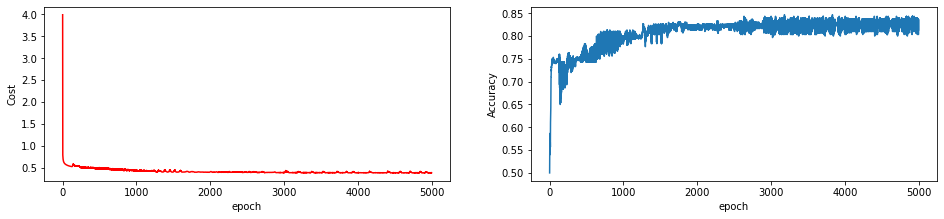

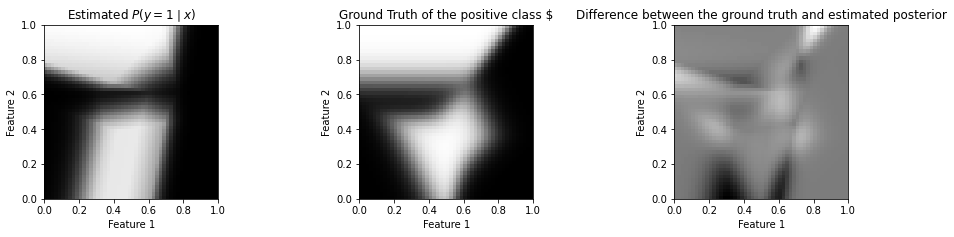

In [25]:
losses_training = nnet_2.losses
accuracy_training = nnet_2.accuracies
visualize_cost_accuracy_curves(accuracy_training, losses_training)
visualize_posterior(nnet_2)

<a id='Compare'></a>
## Compare the two networks below:

Answer:


relu loss 0.392, sigmoid loss 0.3692

The Sigmoid network (i.e. the NN using the sigmoid activation function) seemed to have performed better than the ReLU network -  with a lower loss and higher accuracy at the best epoch. It is usually expected for ReLU to perform better as it avoids issues such as vanishing gradients. In this case, it may not have been observed as the network using ReLU had a lower learning rate than the one using sigmoid. This therefore might have led to the network not achieving its optimal value yet given the number of epochs completed (smaller learning rate = smaller paramter updates = requires more updates)

When comparing the difference between the ground truth and estimated prosterior graphucaly, the ReLU seems to outperform the Sigmoid network.